In [1]:
import os
import cv2
import json
import glob
import shutil
import time

import PBL_detection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PBL_detection import *
from Roots_point_detect_tool import*
from pattern_detection_tool import*
from tqdm.notebook import tqdm as tqdm

In [2]:
step = 2

In [3]:
assert step==1,'modify step'

AssertionError: modify step

In [ ]:
def folder_builder(parent_path,folder_name,Rebuild):
    if os.path.exists(os.path.join(parent_path, folder_name)) and not Rebuild:
        print('"{}" folder is exist,if want to rebuild please modify "Rebuild" parameter.'.format(folder_name))
    else:
        if os.path.exists(os.path.join(parent_path, folder_name)):
            shutil.rmtree(os.path.join(parent_path, folder_name))
        try:
            os.makedirs(os.path.join(parent_path, folder_name))
            print('"{}" folder build successful'.format(folder_name))
        except:
            print('folder build error')

In [ ]:
#First time Rebuild = True
Rebuild = True
folder_build_path = './'
sub_folder_name_list = ['1_o_image','1_roots_mask','1_seg_image','2_seg_img_with_cej',
                        '3_pattern_detection_result','3_draw_all_points_on_o_img',
                        '3_draw_all_points_on_seg_img','4_result_with_label',
                        'csv_file','Result_comparison']

if not Rebuild and os.path.exists(folder_build_path):
    print('This folder is exist,if want to rebuild please modify "Rebuild" parameter.')
else:
    for sub_folder_name in sub_folder_name_list:
        folder_builder(folder_build_path,sub_folder_name,Rebuild)
    print('Initial the all folder.')

In [ ]:
seg_img_list = glob.glob('./preprocess/seg_img/*.PNG')
seg_img_list.sort()

o_img_path_list = glob.glob('./preprocess/o_img/*.PNG')
print(len(o_img_path_list))
root_img_path_list = glob.glob('./preprocess/root_mask_img/*.PNG')
print(len(root_img_path_list))

o_img_save_path = './1_o_image'
root_save_path = './1_roots_mask'
seg_img_save_path = './1_seg_image'

count=0

for seg_img_path in tqdm(seg_img_list,total=len(seg_img_list)):
    image_name = seg_img_path.split('/')[-1].split('.')[0]
    o_img_path = [img_path for img_path in o_img_path_list if image_name in img_path]
    root_img_path = [img_path for img_path in root_img_path_list if image_name in img_path]
    
    if o_img_path==[] or root_img_path==[]:
        count+=1
        pass
    for img in o_img_path:
        img_shape = cv2.imread(img).shape 
        shutil.copy(img,os.path.join(o_img_save_path,image_name+'.PNG'))
        
    seg_resize = cv2.resize(cv2.imread(seg_img_path),(img_shape[1],img_shape[0]),interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(os.path.join(seg_img_save_path,image_name+'.PNG'),seg_resize)
#     for img in root_img_path:
#         root_name = img.split('/')[-1].split('.')[0]
#         root = cv2.imread(img)
#         root_resize = cv2.resize(root,(img_shape[1],img_shape[0]),interpolation=cv2.INTER_NEAREST)
#         cv2.imwrite(os.path.join(root_save_path,root_name+'.PNG'),root_resize)
print(count)

In [ ]:
seg_img_list = glob.glob('./preprocess/seg_img/*.PNG')
seg_img_list.sort()

o_img_list = glob.glob('./preprocess/o_img/*.PNG')
o_img_list.sort()

root_img_list = glob.glob('./1_roots_mask/*.PNG')
root_img_list.sort()
print(len(seg_img_list),len(o_img_list),len(root_img_list))

o_img_save_path = './1_o_image'
seg_img_save_path = './1_seg_image'

count = 0

for o,s in tqdm(zip(o_img_list,seg_img_list),total=len(seg_img_list)):
    o_img = cv2.imread(o)
    s_img = cv2.imread(s)
    assert o.split('/')[-1] == s.split('/')[-1],'fuck you'
    img_name = o.split('/')[-1][:-4]
    try:
        target_img = [img_path for img_path in root_img_list if img_name in img_path] 
        target_size = cv2.imread(target_img[0]).shape
        o_img_resize = cv2.resize(o_img,(target_size[:2][::-1]), interpolation=cv2.INTER_NEAREST)
        s_img_resize = cv2.resize(s_img,(target_size[:2][::-1]), interpolation=cv2.INTER_NEAREST)
        cv2.imwrite(os.path.join(o_img_save_path,o.split('/')[-1]),o_img_resize)
        cv2.imwrite(os.path.join(seg_img_save_path,s.split('/')[-1]),s_img_resize)
    except:
        print(img_name)
        count+=1

In [ ]:
assert step==2,'modify step can run step 2'

In [ ]:
# def find_tangent_intersection_point(line_of_inertia, mask):
#     y_, x_ = np.nonzero(mask)
#     point_list = [(x, y) for x, y in zip(x_, y_)]
#     point_list.sort(key = lambda x:x[0])
#     return (point_list[0],point_list[-1])

def get_boundary_line_by_inertia(root_mask, tooth_mask):
    root_x, root_y,line_of_inertia = root_point_detect(root_mask,1)
    print(line_of_inertia)
    
#     root_mask_RGB = cv2.cvtColor(root_mask, cv2.COLOR_GRAY2RGB)
    
#     root_mask_RGB1 = root_mask_RGB.copy()
#     cv2.line(root_mask_RGB1, line_of_inertia[0], line_of_inertia[1], (0, 0, 255), 5)
#     plt.imshow(root_mask_RGB1)
#     plt.show()
    
#     root_mask_RGB2 = root_mask_RGB.copy()
    blank_image = np.zeros((root_mask.shape[0],root_mask.shape[1]), np.uint8)
    cv2.line(blank_image, line_of_inertia[0], line_of_inertia[1], (255), 5)
    y_, x_ = np.nonzero(blank_image)
#     print(blank_image.shape)
    inertia_point_list = [(x,y) for x, y in zip(x_,y_)]
    inertia_point_list = list(sorted(inertia_point_list, key = lambda x:x[1]))
#     line_of_inertia = ((inertia_point_list[0][0], inertia_point_list[0][1]),(inertia_point_list[-1][0], inertia_point_list[-1][1]))
#     cv2.line(root_mask_RGB2, line_of_inertia[0], line_of_inertia[1], (0, 0, 255), 5)
    
    min_x = min(inertia_point_list[0][0],inertia_point_list[-1][0])
    max_x = max(inertia_point_list[0][0],inertia_point_list[-1][0])
    final_mask = np.zeros((root_mask.shape[0],root_mask.shape[1]), np.uint8)
    for i in range(-max_x, root_mask.shape[1]-min_x, 1):
        line_n = np.concatenate((blank_image[:,-i:], blank_image[:,:-i]), axis=1)
        if (np.any(line_n*root_mask==1)):
            final_mask+=line_n
    plt.imshow(final_mask)
    plt.show()
    plt.imshow(final_mask*tooth_mask)
    plt.show()
    and_mask = np.where(final_mask*tooth_mask > 0,1,0).astype('uint8')

    target_mask = biggest_components(and_mask, np.where(root_mask > 0,1,0).astype('uint8'))
    plt.figure(figsize=(12,12))
    plt.subplot(121)
    plt.imshow(and_mask)
    plt.subplot(122)
    plt.imshow(target_mask)
    plt.show()
    return target_mask/255

In [ ]:
def biggest_components(mask, root_mask): 
    out_image = np.zeros((mask.shape[0],mask.shape[1]), np.uint8).astype('uint8')
    mask_255 = mask*255
    mask_threshold = cv2.threshold(mask_255, 127, 255, cv2.THRESH_BINARY)[1]
    num_labels, labels_im = cv2.connectedComponents(mask_threshold)
    pixel_num_dict = show_pixel_set(labels_im)
    key_list = list(pixel_num_dict.keys())[1:]
    for ele in key_list:
        target_mask = np.where(labels_im==ele, 1, 0).astype('uint8')
        if (np.any((target_mask*root_mask)==1)):
            out_image+=target_mask
    try:
        return out_image*255
    except:
        return mask_255

In [ ]:
#STEP 2 Using split root_dilation to be mask,shift the root to match cej,
folder_build_path = './'

seg_image_folder = os.path.join(folder_build_path,'1_seg_image')
seg_image_path_list = glob.glob(seg_image_folder+'/*.PNG')
seg_image_path_list.sort()

split_root_folder = os.path.join(folder_build_path,'1_roots_mask')
split_root_path_list = glob.glob(split_root_folder+'/*.PNG')
split_root_path_list.sort()

seg_img_with_cej_save_path = os.path.join(folder_build_path,'2_filled_test')

have_save_path = os.path.join(folder_build_path,'2_filled_test')
have_save_path_list = glob.glob(have_save_path+'/*.PNG')
have_save_path_list.sort()

# if show,save = true would show,save image what this block create
show = True
save = True
save_file_type = '.PNG'
print_ = False

seg_image_path_list = seg_image_path_list[:]

#seg_image_path_list = seg_image_path_list[:10]

for index, seg_image_path in tqdm(enumerate(seg_image_path_list), total = len(seg_image_path_list)):
    img_name = get_name_from_path(seg_image_path,False)
    if print_:
        print(img_name)
    if 'NN_180829_111336_16DC2D' not in img_name:
        continue
    roots_img_path_list = [root_name for root_name in split_root_path_list if img_name in root_name]
    have_fill_num = [root_name for root_name in have_save_path_list if img_name in root_name]
    
#     if len(roots_img_path_list)==len(have_fill_num):
#         continue
    
    o_img = cv2.imread(seg_image_path.replace('1_seg_image','1_o_image'),0)    
    seg_img = cv2.imread(seg_image_path)

    if print_:
        print(show_pixel_set(seg_img))

    #seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)
    seg_img_copy = seg_img.copy()
    seg_img_copy_gray = cv2.cvtColor(seg_img_copy, cv2.COLOR_BGR2GRAY)
    
    tooth_mask = np.where(seg_img_copy_gray==226,1,0).astype('uint8')
    forward, value = tooth_forward(seg_img)
    
    if print_:
        check_status(value)
        
    if show:
        plt.figure(figsize=(12,12))
        plt.subplot(121)
        plt.title('seg_img')
        plt.imshow(cv2.cvtColor(seg_img_copy,cv2.COLOR_BGR2RGB))
        plt.subplot(122)
        plt.title('o_img')
        plt.imshow(o_img, cmap = 'gray')
        plt.show()
    for o_root_path in roots_img_path_list:
        root_name = o_root_path.split('/')[-1]
        o_root_img = cv2.imread(o_root_path,0)
        o_root_img = cv2.resize(o_root_img,o_img.shape[:2][::-1],interpolation = cv2.INTER_NEAREST)
        
#         root_x, root_y,line_of_inertia = root_point_detect(o_root_img,1)
        o_root_img_RGB = cv2.cvtColor(o_root_img, cv2.COLOR_GRAY2RGB)
        plt.imshow(o_root_img_RGB)
        plt.show()
        fill_up_ = get_boundary_line_by_inertia(o_root_img, tooth_mask)

#         fill_up_ = img_dilation(o_root_img,tooth_mask,22)
        seg_img_with_cej = combine_seg_cej(seg_img_copy, fill_up_).astype('uint8')
        plt.figure(figsize=(12, 12))
        plt.subplot(131)
        plt.imshow(o_root_img)
        plt.subplot(132)
        plt.imshow(tooth_mask)
        plt.subplot(133)
        plt.imshow(o_root_img*tooth_mask)
        plt.show()
        plt.figure(figsize=(12, 12))
        plt.subplot(121)
        plt.imshow(fill_up_)
        plt.subplot(122)
        plt.imshow(seg_img_with_cej)
        plt.show()
        print('-----------------------------------------------')
        if save:
            cv2.imwrite(os.path.join(seg_img_with_cej_save_path, root_name), seg_img_with_cej)
        if show:
            plt.figure(figsize=(12,12))
            plt.subplot(141)
            plt.title('fill_up_')
            plt.imshow(fill_up_)
            plt.subplot(142)
            plt.title('tooth_mask')
            plt.imshow(tooth_mask, cmap = 'gray')
            plt.subplot(143)
            plt.title('o_root_img')
            plt.imshow(o_root_img, cmap = 'gray')
            plt.subplot(144)
            plt.title('seg_img_with_cej')
            plt.imshow(cv2.cvtColor(seg_img_with_cej,cv2.COLOR_BGR2RGB))
            plt.show()

In [ ]:
# assert step==3,'modify step can run step 3'

In [4]:
# #initial csv file
# Resave = True
# csv_file_path = './PBL_result_1.csv'

# if not Resave and os.path.exists(csv_file_path):
#     print('This csv file is exist,if want to resave please modify "Resave" parameter.')
# else:
#     print('Initial the csv.')
#     with open(csv_file_path, 'w', newline='\n') as csvfile:
#         csv_writer = csv.writer(csvfile)
#         csv_writer.writerow(['Image_name', 'Tooth_num', 'LPBL(%)', 'L_Stage(int)', 'RPBL(%)', 'R_Stage(int)','Dis_L','Dis_R','Dis_root','points_info','tooth_pbl_line_path'])

In [5]:
# def PBL_Detect(fill_up_img,imgarray,roots_point,cej_points,bone_points,line_of_inertia):
#     print_ = False
#     roots_point = list(sorted(roots_point, key = lambda x:x[0]))
#     cej_points = list(sorted(cej_points, key = lambda x:x[0]))
#     bone_points = list(sorted(bone_points, key = lambda x:x[0]))
#     RGB_image = cv2.cvtColor(imgarray, cv2.COLOR_GRAY2RGB)
#     img_PBL_line = RGB_image.copy()
#     L_side = False
#     R_side = False
#     cej_num_list = [point_in_left_side_of_line(cej,line_of_inertia[0],line_of_inertia[1]) for cej in cej_points]
#     bone_num_list = [point_in_left_side_of_line(bone,line_of_inertia[0],line_of_inertia[1]) for bone in bone_points]
#     if sum(cej_num_list) == 1 and sum(bone_num_list) == 1:
#         L_side = True
#     if len(cej_points) - sum(cej_num_list) == 1 and len(bone_points) - sum(bone_num_list)==1:
#         R_side = True
#     #print("L_side:",L_side,"R_side:",R_side)
#     points_info = tuple((sum(cej_num_list),sum(bone_num_list),len(cej_points) - sum(cej_num_list),len(bone_points) - sum(bone_num_list)))
#     if print_:
#         print('L_side:',L_side,'R_side:',R_side)
#         print('roots_point:',roots_point)
#         print('bone_points:',bone_points)
#         print('cej_points:',cej_points)
#     if L_side and R_side:
#         cej_center_point = [int((cej_points[0][0]+cej_points[1][0])/2),int((cej_points[0][1]+cej_points[1][1])/2)]
#         cv2.line(img_PBL_line, (bone_points[0][0], bone_points[0][1]), (bone_points[1][0], bone_points[1][1]), (0, 255, 0), 5)
#         cv2.line(img_PBL_line, (cej_points[0][0], cej_points[0][1]), (cej_points[1][0], cej_points[1][1]), (255, 0, 0), 5)
#         cv2.line(img_PBL_line, (roots_point[0][0], roots_point[0][1]), (cej_center_point[0], cej_center_point[1]), (0, 0, 255), 5)
        
#         cv2.line(img_PBL_line, (cej_points[0][0],cej_points[0][1]), (bone_points[0][0], bone_points[0][1]), (0, 255, 0), 2)
#         cv2.line(img_PBL_line, (cej_points[1][0],cej_points[1][1]), (bone_points[1][0], bone_points[1][1]), (0, 255, 0), 2)
#         #cv2.line(img_PBL_line, (crosspoint_point2line(bone_points[0],cej_points[0],cej_points[1])), (bone_points[0][0], bone_points[0][1]), (0, 255, 0), 2)
#         #cv2.line(img_PBL_line, (crosspoint_point2line(bone_points[1],cej_points[0],cej_points[1])), (bone_points[1][0], bone_points[1][1]), (0, 255, 0), 2)
        
#         cv2.circle(img_PBL_line, (roots_point[0][0], roots_point[0][1]), 3 , (0, 0, 255), 10)
#         cv2.circle(img_PBL_line, (bone_points[0][0], bone_points[0][1]), 3 , (0, 255, 0), 10)
#         cv2.circle(img_PBL_line, (bone_points[1][0], bone_points[1][1]), 3 , (0, 255, 0), 10)
#         cv2.circle(img_PBL_line, (cej_points[0][0], cej_points[0][1]), 3 , (255, 0, 0), 10)
#         cv2.circle(img_PBL_line, (cej_points[1][0], cej_points[1][1]), 3 , (255, 0, 0), 10)
#         LPBL = (distance_point2line(np.array(bone_points[0]),np.array(cej_points[0]),np.array(cej_points[1]))*0.05-2)/(distance_2_points(np.array(roots_point[0]),np.array(cej_center_point))*0.05-2)
#         RPBL = (distance_point2line(np.array(bone_points[1]),np.array(cej_points[0]),np.array(cej_points[1]))*0.05-2)/(distance_2_points(np.array(roots_point[0]),np.array(cej_center_point))*0.05-2)

#         Dis_L = distance_point2line(np.array(bone_points[0]),np.array(cej_points[0]),np.array(cej_points[1]))
#         Dis_R = distance_point2line(np.array(bone_points[1]),np.array(cej_points[0]),np.array(cej_points[1]))
#         Dis_root = distance_2_points(np.array(roots_point[0]),np.array(cej_center_point))
#         if LPBL < 0:
#             LPBL = 0
#         if RPBL < 0:
#             RPBL = 0
#         return True, round(LPBL*100,3), PBL_stage(LPBL), round(RPBL*100,3), PBL_stage(RPBL),Dis_L,Dis_R,Dis_root, img_PBL_line,points_info
#     elif L_side:
#         RPBL = -999
#         cej_cross_point_with_inertia = crosspoint_point2line(cej_points[cej_num_list.index(True)],line_of_inertia[0],line_of_inertia[1])
#         bone_cross_point_with_inertia = crosspoint_point2line(bone_points[bone_num_list.index(True)],line_of_inertia[0],line_of_inertia[1])
#         cv2.line(img_PBL_line, (roots_point[0][0], roots_point[0][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (0, 0, 255), 5)
#         cv2.line(img_PBL_line, (cej_points[cej_num_list.index(True)][0], cej_points[cej_num_list.index(True)][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (255, 0, 0), 5)
#         cv2.line(img_PBL_line, (bone_points[bone_num_list.index(True)][0], bone_points[bone_num_list.index(True)][1]), (bone_cross_point_with_inertia[0], bone_cross_point_with_inertia[1]), (0, 255, 0), 5)
#         cv2.line(img_PBL_line, (cej_points[cej_num_list.index(True)][0],cej_points[cej_num_list.index(True)][1]), (bone_points[bone_num_list.index(True)][0], bone_points[bone_num_list.index(True)][1]), (0, 255, 0), 2)
#         LPBL = (distance_2_points(np.array(cej_points[cej_num_list.index(True)]),np.array(bone_points[bone_num_list.index(True)]))*0.05-2)/(distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))*0.05-2)
#         Dis_R = -999
#         Dis_L = distance_2_points(np.array(cej_points[cej_num_list.index(True)]),np.array(bone_points[bone_num_list.index(True)]))
#         Dis_root = distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))
#         if LPBL < 0:
#             LPBL = 0
#         return True, round(LPBL*100,3), PBL_stage(LPBL), RPBL, PBL_stage(RPBL),Dis_L,Dis_R,Dis_root,img_PBL_line,points_info
#     elif R_side:
#         LPBL = -999
#         cej_cross_point_with_inertia = crosspoint_point2line(cej_points[cej_num_list.index(False)],line_of_inertia[0],line_of_inertia[1])
#         bone_cross_point_with_inertia = crosspoint_point2line(bone_points[bone_num_list.index(False)],line_of_inertia[0],line_of_inertia[1])
#         cv2.line(img_PBL_line, (roots_point[0][0], roots_point[0][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (0, 0, 255), 5)
#         cv2.line(img_PBL_line, (cej_points[cej_num_list.index(False)][0], cej_points[cej_num_list.index(False)][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (255, 0, 0), 5)
#         cv2.line(img_PBL_line, (bone_points[bone_num_list.index(False)][0], bone_points[bone_num_list.index(False)][1]), (bone_cross_point_with_inertia[0], bone_cross_point_with_inertia[1]), (0, 255, 0), 5)
#         cv2.line(img_PBL_line, (cej_points[cej_num_list.index(False)][0],cej_points[cej_num_list.index(False)][1]), (bone_points[bone_num_list.index(False)][0], bone_points[bone_num_list.index(False)][1]), (0, 255, 0), 2)
#         RPBL = (distance_2_points(np.array(cej_points[cej_num_list.index(False)]),np.array(bone_points[bone_num_list.index(False)]))*0.05-2)/(distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))*0.05-2)
#         Dis_L = -999
#         Dis_R = distance_2_points(np.array(cej_points[cej_num_list.index(False)]),np.array(bone_points[bone_num_list.index(False)]))
#         Dis_root = distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))
#         if RPBL < 0:
#             RPBL = 0
#         return True, LPBL, PBL_stage(LPBL), round(RPBL*100,3), PBL_stage(RPBL),Dis_L,Dis_R,Dis_root,img_PBL_line,points_info
#     else:
#         LPBL, RPBL = -999, -999
#         Dis_L = -999
#         Dis_R = -999
#         Dis_root = -999
#         img_PBL_line_copy = img_PBL_line.copy()
#         fill_up_img = np.expand_dims(fill_up_img, axis=2)
#         fill_up_img = np.where(fill_up_img>0,1,0).astype('uint8')
#         cv2.line(img_PBL_line_copy, (line_of_inertia[0][0], line_of_inertia[0][1]), (line_of_inertia[1][0], line_of_inertia[1][1]), (0, 0, 255), 5)
#         img_PBL_line_copy*=fill_up_img
#         img_PBL_line*=abs(1-fill_up_img)
#         img_PBL_line += img_PBL_line_copy
#         return False,LPBL, PBL_stage(LPBL), RPBL, PBL_stage(RPBL),Dis_L,Dis_R,Dis_root,img_PBL_line,points_info

In [6]:
def PBL_Detect(fill_up_img, value, imgarray, roots_point, cej_points,bone_points, line_of_inertia, molar):
    print_ = False
    roots_point = list(sorted(roots_point, key = lambda x:x[0]))
    cej_points = list(sorted(cej_points, key = lambda x:x[0]))
    bone_points = list(sorted(bone_points, key = lambda x:x[0]))
    RGB_image = cv2.cvtColor(imgarray, cv2.COLOR_GRAY2RGB)
    img_PBL_line = RGB_image.copy()
    L_side = False
    R_side = False
    
    cej_num_list = [point_in_left_side_of_line(cej,line_of_inertia[0],line_of_inertia[1]) for cej in cej_points]
    bone_num_list = [point_in_left_side_of_line(bone,line_of_inertia[0],line_of_inertia[1]) for bone in bone_points]
    
    print(cej_num_list)
    print(bone_num_list)
    line_of_inertia_copy = line_of_inertia.copy()
    
    if sum(cej_num_list) == 1 and sum(bone_num_list) == 1:
        L_side = True
    if len(cej_points) - sum(cej_num_list) == 1 and len(bone_points) - sum(bone_num_list)==1:
        R_side = True
    #print("L_side:",L_side,"R_side:",R_side)
    
    LPBL, RPBL = -999, -999
    Dis_L = -999
    Dis_R = -999
    Dis_root = -999
    
    points_info = tuple((sum(cej_num_list),sum(bone_num_list),len(cej_points) - sum(cej_num_list),len(bone_points) - sum(bone_num_list)))
    if print_:
        print('L_side:',L_side,'R_side:',R_side)
        print('roots_point:',roots_point)
        print('bone_points:',bone_points)
        print('cej_points:',cej_points)
#     molar = False

#     if L_side and R_side and not molar:
#         cej_center_point = [int((cej_points[0][0]+cej_points[1][0])/2),int((cej_points[0][1]+cej_points[1][1])/2)]
#         cv2.line(img_PBL_line, (bone_points[0][0], bone_points[0][1]), (bone_points[1][0], bone_points[1][1]), (0, 255, 0), 5)
#         cv2.line(img_PBL_line, (cej_points[0][0], cej_points[0][1]), (cej_points[1][0], cej_points[1][1]), (255, 0, 0), 5)
#         cv2.line(img_PBL_line, (roots_point[0][0], roots_point[0][1]), (cej_center_point[0], cej_center_point[1]), (0, 0, 255), 5)

#         cv2.line(img_PBL_line, (cej_points[0][0],cej_points[0][1]), (bone_points[0][0], bone_points[0][1]), (0, 255, 0), 2)
#         cv2.line(img_PBL_line, (cej_points[1][0],cej_points[1][1]), (bone_points[1][0], bone_points[1][1]), (0, 255, 0), 2)
#         #cv2.line(img_PBL_line, (crosspoint_point2line(bone_points[0],cej_points[0],cej_points[1])), (bone_points[0][0], bone_points[0][1]), (0, 255, 0), 2)
#         #cv2.line(img_PBL_line, (crosspoint_point2line(bone_points[1],cej_points[0],cej_points[1])), (bone_points[1][0], bone_points[1][1]), (0, 255, 0), 2)

#         cv2.circle(img_PBL_line, (roots_point[0][0], roots_point[0][1]), 3 , (0, 0, 255), 10)
#         cv2.circle(img_PBL_line, (bone_points[0][0], bone_points[0][1]), 3 , (0, 255, 0), 10)
#         cv2.circle(img_PBL_line, (bone_points[1][0], bone_points[1][1]), 3 , (0, 255, 0), 10)
#         cv2.circle(img_PBL_line, (cej_points[0][0], cej_points[0][1]), 3 , (255, 0, 0), 10)
#         cv2.circle(img_PBL_line, (cej_points[1][0], cej_points[1][1]), 3 , (255, 0, 0), 10)
#         LPBL = (distance_point2line(np.array(bone_points[0]),np.array(cej_points[0]),np.array(cej_points[1]))*0.05-2)/(distance_2_points(np.array(roots_point[0]),np.array(cej_center_point))*0.05-2)
#         RPBL = (distance_point2line(np.array(bone_points[1]),np.array(cej_points[0]),np.array(cej_points[1]))*0.05-2)/(distance_2_points(np.array(roots_point[0]),np.array(cej_center_point))*0.05-2)

#         Dis_L = distance_point2line(np.array(bone_points[0]),np.array(cej_points[0]),np.array(cej_points[1]))
#         Dis_R = distance_point2line(np.array(bone_points[1]),np.array(cej_points[0]),np.array(cej_points[1]))
#         Dis_root = distance_2_points(np.array(roots_point[0]),np.array(cej_center_point))
#         if LPBL < 0:
#             LPBL = 0
#         if RPBL < 0:
#             RPBL = 0
#         return True, round(LPBL*100,3), PBL_stage(LPBL), round(RPBL*100,3), PBL_stage(RPBL),Dis_L,Dis_R,Dis_root, img_PBL_line,points_info
    if L_side:
        if molar:
            root_x, root_y, line_of_inertia = get_molar_root(fill_up_img, value, line_of_inertia, 'L')
            roots_point = list(sorted(zip(root_x, root_y), key = lambda x:x[0]))
            cej_num_list = [point_in_left_side_of_line(cej,line_of_inertia[0],line_of_inertia[1]) for cej in cej_points]
            bone_num_list = [point_in_left_side_of_line(bone,line_of_inertia[0],line_of_inertia[1]) for bone in bone_points]
            
        if sum(cej_num_list) == 1 and sum(bone_num_list) == 1:
            cej_cross_point_with_inertia = crosspoint_point2line(cej_points[cej_num_list.index(True)],line_of_inertia[0],line_of_inertia[1])
            bone_cross_point_with_inertia = crosspoint_point2line(bone_points[bone_num_list.index(True)],line_of_inertia[0],line_of_inertia[1])

            cv2.circle(img_PBL_line, (roots_point[0]), 5, (0, 0, 255), -1)
            cv2.line(img_PBL_line, (roots_point[0][0], roots_point[0][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (0, 0, 255), 5)
            cv2.line(img_PBL_line, (cej_points[cej_num_list.index(True)][0], cej_points[cej_num_list.index(True)][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (255, 0, 0), 5)
            cv2.line(img_PBL_line, (bone_points[bone_num_list.index(True)][0], bone_points[bone_num_list.index(True)][1]), (bone_cross_point_with_inertia[0], bone_cross_point_with_inertia[1]), (0, 255, 0), 5)
            cv2.line(img_PBL_line, (cej_points[cej_num_list.index(True)][0],cej_points[cej_num_list.index(True)][1]), (bone_points[bone_num_list.index(True)][0], bone_points[bone_num_list.index(True)][1]), (0, 255, 0), 2)

            LPBL = (distance_2_points(np.array(cej_points[cej_num_list.index(True)]),np.array(bone_points[bone_num_list.index(True)]))*0.05-2)/(distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))*0.05-2)
            Dis_L = distance_2_points(np.array(cej_points[cej_num_list.index(True)]),np.array(bone_points[bone_num_list.index(True)]))
            Dis_root = distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))
            if LPBL < 0:
                LPBL = 0
        else:
            pass

    if R_side:
        if molar:
            root_x, root_y, line_of_inertia = get_molar_root(fill_up_img, value, line_of_inertia_copy, 'R')
            roots_point = list(sorted(zip(root_x, root_y), key = lambda x:x[0]))
            cej_num_list = [point_in_left_side_of_line(cej,line_of_inertia[0],line_of_inertia[1]) for cej in cej_points]
            bone_num_list = [point_in_left_side_of_line(bone,line_of_inertia[0],line_of_inertia[1]) for bone in bone_points]
        if ((len(cej_num_list) - sum(cej_num_list)) == 1) and ((len(bone_points) - sum(bone_num_list))==1):      
            cej_cross_point_with_inertia = crosspoint_point2line(cej_points[cej_num_list.index(False)],line_of_inertia[0],line_of_inertia[1])
            bone_cross_point_with_inertia = crosspoint_point2line(bone_points[bone_num_list.index(False)],line_of_inertia[0],line_of_inertia[1])

            cv2.circle(img_PBL_line, (roots_point[0]), 5, (0, 0, 255), -1)
            cv2.line(img_PBL_line, (roots_point[0][0], roots_point[0][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (0, 0, 255), 5)
            cv2.line(img_PBL_line, (cej_points[cej_num_list.index(False)][0], cej_points[cej_num_list.index(False)][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (255, 0, 0), 5)
            cv2.line(img_PBL_line, (bone_points[bone_num_list.index(False)][0], bone_points[bone_num_list.index(False)][1]), (bone_cross_point_with_inertia[0], bone_cross_point_with_inertia[1]), (0, 255, 0), 5)
            cv2.line(img_PBL_line, (cej_points[cej_num_list.index(False)][0],cej_points[cej_num_list.index(False)][1]), (bone_points[bone_num_list.index(False)][0], bone_points[bone_num_list.index(False)][1]), (0, 255, 0), 2)

            RPBL = (distance_2_points(np.array(cej_points[cej_num_list.index(False)]),np.array(bone_points[bone_num_list.index(False)]))*0.05-2)/(distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))*0.05-2)
            Dis_R = distance_2_points(np.array(cej_points[cej_num_list.index(False)]),np.array(bone_points[bone_num_list.index(False)]))
            Dis_root = distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))
            if RPBL < 0:
                RPBL = 0
        else:
            pass
            
    if L_side or R_side:
        return True, max(round(LPBL*100,3), -999), PBL_stage(LPBL), max(round(RPBL*100,3), -999), PBL_stage(RPBL),Dis_L,Dis_R,Dis_root,img_PBL_line,points_info
    else:
        LPBL, RPBL = -999, -999
        Dis_L = -999
        Dis_R = -999
        Dis_root = -999
        img_PBL_line_copy = img_PBL_line.copy()
        fill_up_img = np.expand_dims(fill_up_img, axis=2)
        fill_up_img = np.where(fill_up_img>0,1,0).astype('uint8')
        cv2.line(img_PBL_line_copy, (line_of_inertia[0][0], line_of_inertia[0][1]), (line_of_inertia[1][0], line_of_inertia[1][1]), (0, 0, 255), 5)
        img_PBL_line_copy*=fill_up_img
        img_PBL_line*=abs(1-fill_up_img)
        img_PBL_line += img_PBL_line_copy
        return False,LPBL, PBL_stage(LPBL), RPBL, PBL_stage(RPBL),Dis_L,Dis_R,Dis_root,img_PBL_line,points_info

In [7]:
# #bone is follow to cej
# def keypoint_filter(cej_points, bone_points, line_of_inertia, value, fill_up_img):
#     new_list_x = []
#     new_list_y = []
#     cej_points = list(sorted(cej_points, key = lambda x:x[0]))
#     bone_points = list(sorted(bone_points, key = lambda x:x[0]))
    
# #     root_x, root_y, line_of_inertia_L = get_molar_root(fill_up_img, value, line_of_inertia, 'L')
# #     root_x, root_y, line_of_inertia_R = get_molar_root(fill_up_img, value, line_of_inertia, 'R')
    
# #     cej_num_list = [point_in_left_side_of_line(cej,line_of_inertia[0],line_of_inertia[1]) for cej in cej_points]
# #     bone_num_list = [point_in_left_side_of_line(bone,line_of_inertia[0],line_of_inertia[1]) for bone in bone_points]

#     root_x, root_y, line_of_inertia_L = get_molar_root(fill_up_img, value, line_of_inertia, 'L')
#     cej_num_list_L = [point_in_left_side_of_line(cej,line_of_inertia_L[0],line_of_inertia_L[1]) for cej in cej_points]
#     root_x, root_y, line_of_inertia_R = get_molar_root(fill_up_img, value, line_of_inertia, 'R')
#     cej_num_list_R = [point_in_left_side_of_line(cej,line_of_inertia_R[0],line_of_inertia_R[1]) for cej in cej_points]
    
# #     bone_num_list = [point_in_left_side_of_line(bone,line_of_inertia[0],line_of_inertia[1]) for bone in bone_points]
    
    
# #     cej_left_points = [cej for bool_left,cej in zip(cej_num_list,cej_points) if bool_left]
# #     cej_right_points = [cej for bool_left,cej in zip(cej_num_list,cej_points) if not bool_left]
#     cej_left_points = [cej for bool_left,cej in zip(cej_num_list_L,cej_points) if bool_left]
#     cej_right_points = [cej for bool_left,cej in zip(cej_num_list_R,cej_points) if not bool_left]
    
#     cej_x = []
#     cej_y = []
#     #upper tooth
#     if (value==1):
#         try:
#             cej_left_points = list(sorted(cej_left_points, key = lambda x:x[1]))[0]
#             cej_points.append(cej_left_points)
#             cej_x.append(cej_left_points[0])
#             cej_y.append(cej_left_points[1])
#         except:
#             pass
#         try:
#             cej_right_points = list(sorted(cej_right_points, key = lambda x:x[1]))[0]
#             cej_points.append(cej_right_points)
#             cej_x.append(cej_right_points[0])
#             cej_y.append(cej_right_points[1])
#         except:
#             pass
#     #lower tooth
#     if (value==0):
#         try:
#             cej_left_points = list(sorted(cej_left_points, key = lambda x:x[1],reverse=True))[0]
#             cej_points.append(cej_left_points)
#             cej_x.append(cej_left_points[0])
#             cej_y.append(cej_left_points[1])
#         except:
#             pass
#         try:
#             cej_right_points = list(sorted(cej_right_points, key = lambda x:x[1],reverse=True))[0]
#             cej_points.append(cej_right_points)
#             cej_x.append(cej_right_points[0])
#             cej_y.append(cej_right_points[1])
#         except:
#             pass
    
#     cej_final_points = [(x,y) for x,y in zip(cej_x,cej_y)]
#     cej_left_bool_list = [point_in_left_side_of_line(cej,line_of_inertia[0],line_of_inertia[1]) for cej in cej_final_points]
    
#     root_x, root_y, line_of_inertia_L = get_molar_root(fill_up_img, value, line_of_inertia, 'L')
#     bone_num_list_L = [point_in_left_side_of_line(bone, line_of_inertia_L[0], line_of_inertia_L[1]) for bone in bone_points]
#     root_x, root_y, line_of_inertia_R = get_molar_root(fill_up_img, value, line_of_inertia, 'R')
#     bone_num_list_R = [point_in_left_side_of_line(bone, line_of_inertia_R[0], line_of_inertia_R[1]) for bone in bone_points]
 
#     bone_left_points = [bone for bool_left,bone in zip(bone_num_list_L,bone_points) if  bool_left]
#     bone_right_points = [bone for bool_left,bone in zip(bone_num_list_R,bone_points) if not bool_left]
    
# #     bone_left_points = [bone for bool_left,bone in zip(bone_num_list,bone_points) if  bool_left]
# #     bone_right_points = [bone for bool_left,bone in zip(bone_num_list,bone_points) if not bool_left]
    
#     bone_x = []
#     bone_y = []
# #     print("-------------------------------")
# #     print("line_of_inertia[0],line_of_inertia[1]",line_of_inertia[0],line_of_inertia[1])
# #     print("cej_final_points:",cej_final_points)
# #     print("cej_final_side:",cej_num_list)
    
# #     print(len(bone_num_list))
# #     print("cej_num_list:",cej_num_list)
# #     print("cej_right_points:",cej_right_points)
# #     print("cej_left_points:",cej_left_points)
    
# #     print("bone_num_list:",bone_num_list)
# #     print("bone_right_points:",bone_right_points)
# #     print("bone_left_points:",bone_left_points)
# #     print("cej_x:",cej_x)
# #     print("cej_y:",cej_y)
    
#     #upper tooth
#     if (value==1):
#         try:
#             bone_left_points = list(sorted(bone_left_points, key = lambda x:x[1],reverse=True))
#             bone_left_points_exclude_on_crown = [(x,y) for (x,y) in bone_left_points if y < cej_y[cej_left_bool_list.index(True)]]
#             best_point = bone_left_points_exclude_on_crown[0]
#             bone_x.append(best_point[0])
#             bone_y.append(best_point[1])
#         except:
#             pass
#         try:
#             bone_right_points = list(sorted(bone_right_points, key = lambda x:x[1],reverse=True))
#             bone_right_points_exclude_on_crown = [(x,y) for (x,y) in bone_right_points if y < cej_y[cej_left_bool_list.index(False)]]
#             best_point = bone_right_points_exclude_on_crown[0]
#             bone_x.append(best_point[0])
#             bone_y.append(best_point[1])
#         except:
#             pass
#     #lower tooth
#     if (value==0):
#         try:
#             bone_left_points = list(sorted(bone_left_points, key = lambda x:x[1],reverse=False))
#             bone_left_points_exclude_on_crown = [(x,y) for (x,y) in bone_left_points if y > cej_y[cej_left_bool_list.index(True)]]
#             best_point = bone_left_points_exclude_on_crown[0]
#             bone_x.append(best_point[0])
#             bone_y.append(best_point[1])
#         except:
#             pass
#         try:
#             bone_right_points = list(sorted(bone_right_points, key = lambda x:x[1],reverse=False))
#             bone_right_points_exclude_on_crown = [(x,y) for (x,y) in bone_right_points if y > cej_y[cej_left_bool_list.index(False)]]
#             best_point = bone_right_points_exclude_on_crown[0]
#             bone_x.append(best_point[0])
#             bone_y.append(best_point[1])
#         except:
#             pass
# #     print("cej_x:",cej_x,"cej_y:",cej_y)
# #     print("bone_x:",bone_x,"bone_y:",bone_y)
# #     print("-------------------------------")
#     return (cej_x,cej_y),(bone_x,bone_y)

In [8]:
def PolygonArea(corners):
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

def point_in_box(point_boxs_list,check_point):
    point_pair_list = [[point_boxs_list[i-1],point_boxs_list[i]] for i in range(len(point_boxs_list))]
    box_area = PolygonArea(point_boxs_list)
    count_area = 0
    for edge in point_pair_list:
        edge.append(check_point)
        count_area = PolygonArea(edge)+count_area
    if count_area - box_area < 1:
        return True
    else:
        return False
    
def get_molar_bool(json_file_path, check_point):
    with open(json_file_path, 'r') as file:
        json_file = json.load(file)
    for tooth in json_file['shapes']:
        check_in_box = point_in_box(tooth['points'],check_point)
        if check_in_box:
            tooth_num = int(tooth['label'].split('_')[0])
            if (tooth_num >= 1 and tooth_num <=3) or (tooth_num >= 14 and tooth_num <=19) or (tooth_num >= 30 and tooth_num <=32):
                return True
            else:
                return False
    return False

In [9]:
def get_molar_root(fill_up_img, value, line_of_inertia, type_):
    y_list,x_list = np.nonzero(fill_up_img)
    
    L_fill_up = fill_up_img.copy()
    if type_ == 'L':
        point_in_left = [point_in_left_side_of_line([x_,y_],line_of_inertia[0],line_of_inertia[1]) for (x_, y_) in zip(x_list,y_list)]
        for bool_, x_, y_ in zip(point_in_left, x_list, y_list):
            if (not bool_):
                L_fill_up[y_,x_] = 0
        root_x, root_y,line_of_inertia = root_point_detect(L_fill_up,value)
#         plt.imshow(L_fill_up)
#         plt.show()
        return root_x, root_y,line_of_inertia

    if type_ == 'R':
        R_fill_up = fill_up_img.copy()
        point_in_left = [point_in_left_side_of_line([x_,y_],line_of_inertia[0],line_of_inertia[1]) for (x_, y_) in zip(x_list,y_list)]
        for bool_, x_, y_ in zip(point_in_left, x_list, y_list):
            if bool_:
                R_fill_up[y_,x_] = 0          
        root_x, root_y,line_of_inertia = root_point_detect(R_fill_up,value)
#         plt.imshow(R_fill_up)
#         plt.show()
        return root_x, root_y,line_of_inertia

In [10]:
# def find_cej_bone_keypoint(img_BGR_array):
#     kernel = np.ones((5,5),np.uint8)
#     img_gray = cv2.cvtColor(img_BGR_array,cv2.COLOR_BGR2GRAY)
#     tooth = cv2.morphologyEx(np.where(img_gray==94,1,0).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
#     gums = cv2.morphologyEx(np.where(img_gray==29,1,0).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
#     background = cv2.morphologyEx(np.where(img_gray==0,1,np.where(img_gray==86,1,np.where(img_gray==151,1,0))).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
#     cej_crown = cv2.morphologyEx(np.where(img_gray==150,1,np.where(img_gray==179,1,0)).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
#     depression = cv2.morphologyEx(np.where(img_gray==151,1,0).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
#     cej = tooth*background*cej_crown
#     bone = tooth*background*gums
#     cej_point = np.nonzero(cej)
#     bone_point = np.nonzero(bone)
#     return group_points_and_chose_best(cej_point[1],cej_point[0],img_gray),group_points_and_chose_best(bone_point[1],bone_point[0],img_gray)

In [11]:
# def find_cej_bone_keypoint(img_BGR_array):
#     kernel = np.ones((5,5),np.uint8)
#     img_gray = cv2.cvtColor(img_BGR_array,cv2.COLOR_BGR2GRAY)
    
#     tooth_area = np.where(img_gray==94,1,0).astype('uint8')
#     tooth_area_cv = cv2.morphologyEx(tooth_area, cv2.MORPH_OPEN, kernel)
#     tooth_area_cv = cv2.morphologyEx(tooth_area_cv, cv2.MORPH_CLOSE, kernel)
#     tooth_area_cv = cv2.dilate(tooth_area_cv,kernel,iterations = 1)
#     tooth_area_cv = tooth_area_cv*tooth_area
#     tooth = cv2.dilate(tooth_area_cv,kernel,iterations = 2)
# #     tooth = cv2.morphologyEx(tooth_area, cv2.MORPH_GRADIENT, kernel)
    
#     gums_area = np.where(img_gray==29,1,0).astype('uint8')
#     gums_area_cv = cv2.morphologyEx(gums_area, cv2.MORPH_OPEN, kernel)
#     gums_area_cv = cv2.morphologyEx(gums_area_cv, cv2.MORPH_CLOSE, kernel)
#     gums_area_cv = cv2.dilate(gums_area_cv,kernel,iterations = 1)
#     gums_area_cv = gums_area_cv*gums_area
#     gums = cv2.dilate(gums_area_cv,kernel,iterations = 2)
#     #     gums = cv2.morphologyEx(gums_area, cv2.MORPH_GRADIENT, kernel)
    
#     background_area = np.where(img_gray==0,1,np.where(img_gray==86,1,np.where(img_gray==151,1,0))).astype('uint8')
#     background_area_cv = cv2.morphologyEx(background_area, cv2.MORPH_OPEN, kernel)
#     background_area_cv = cv2.morphologyEx(background_area_cv, cv2.MORPH_CLOSE, kernel)
#     background_area_cv = cv2.dilate(background_area_cv,kernel,iterations = 1)
#     background_area_cv = background_area_cv*background_area
#     background = cv2.dilate(background_area_cv,kernel,iterations = 2)
#     #background = cv2.morphologyEx(background_area, cv2.MORPH_GRADIENT, kernel)
    
#     cej_crown_area = np.where(img_gray==150,1,np.where(img_gray==179,1,0)).astype('uint8')
#     cej_crown_area_cv = cv2.morphologyEx(cej_crown_area, cv2.MORPH_OPEN, kernel)
#     cej_crown_area_cv = cv2.morphologyEx(cej_crown_area_cv, cv2.MORPH_CLOSE, kernel)
#     cej_crown_area_cv = cv2.dilate(cej_crown_area_cv,kernel,iterations = 1)
#     cej_crown_area_cv = cej_crown_area_cv*cej_crown_area
#     cej_crown = cv2.dilate(cej_crown_area_cv,kernel,iterations = 2)
#     #cej_crown = cv2.morphologyEx(cej_crown_area_cv, cv2.MORPH_GRADIENT, kernel)
    

#     cej = tooth*background*cej_crown*tooth_area
#     bone = tooth*background*gums*gums_area
#     cej_point = np.nonzero(cej)
#     bone_point = np.nonzero(bone)
#     blank_image = np.zeros((img_BGR_array.shape[0], img_BGR_array.shape[1],3), np.uint8)
# #     plt.imshow(blank_image)
# #     plt.scatter(x=cej_point[1], y=cej_point[0], c='r', s=8)
# #     plt.scatter(x=bone_point[1], y=bone_point[0], c='y', s=8)
# #     plt.show()
    
# #     plt.figure(figsize=(12, 12))
# #     plt.subplot(141)
# #     plt.imshow(tooth)
# #     plt.subplot(142)
# #     plt.imshow(background)
# #     plt.subplot(143)
# #     plt.imshow(cej_crown)
# #     plt.subplot(144)
# #     plt.imshow(tooth_area)
# #     plt.show()
    
# #     plt.figure(figsize=(12, 12))
# #     plt.subplot(141)
# #     plt.imshow(tooth)
# #     plt.subplot(142)
# #     plt.imshow(background)
# #     plt.subplot(143)
# #     plt.imshow(gums)
# #     plt.subplot(144)
# #     plt.imshow(gums_area)
# #     plt.show()
    
# #     plt.figure(figsize=(12, 12))
# #     plt.subplot(121)
# #     plt.imshow(cej)
# #     plt.subplot(122)
# #     plt.imshow(bone)
# #     plt.show()

#     return group_points_and_chose_best(cej_point[1],cej_point[0],img_gray),group_points_and_chose_best(bone_point[1],bone_point[0],img_gray)


In [12]:
def group_points_and_chose_best(list_x, list_y,img):
    new_list_x = []
    new_list_y = []  
    if list_x != [] and list_y != []:
        coords = [[x,y] for x, y in zip(list_x, list_y)]
        boolean = cdist(coords, coords) < 12
        matrix = [[] for __ in range(len(boolean))]
        for row_i, row in enumerate(boolean):
            matrix[row_i] = list([i for i, is_true in enumerate(row) if is_true])
        groups = []
        for pair in matrix:
            if pair not in groups and len(pair) > 1:
                groups.append(pair)
        for group in groups:
#             print(group)
            group_point = [coords[index] for index in group]
            group_point_array = np.array(group_point)
            x_cor = int((sum(group_point_array)/len(group_point_array))[0])
            y_cor = int((sum(group_point_array)/len(group_point_array))[1])
            if x_cor<img.shape[1] and y_cor< img.shape[0]:
                new_list_x.append(x_cor)
                new_list_y.append(y_cor)
    return new_list_x, new_list_y

In [13]:
# def cej_recover(cej_x_list, cej_y_list, line_of_inertia, fill_up_img):
#     blank_image = np.zeros((fill_up_img.shape[0],fill_up_img.shape[1]), np.uint8)
#     cej_x = cej_x_list[0]
#     cej_y = cej_y_list[0]
#     cej_cross_point_with_inertia = crosspoint_point2line((cej_x, cej_y),line_of_inertia[0],line_of_inertia[1])
#     center_x = cej_cross_point_with_inertia[0]
#     center_y = cej_cross_point_with_inertia[1]
#     vecter_x = (center_x-cej_x)*50
#     vecter_y = (center_y-cej_y)*50
#     cv2.line(blank_image, (cej_x-vecter_x, cej_y-vecter_y), (center_x+vecter_x, center_y+vecter_y), (1), 5)
#     plt.imshow(blank_image)
#     plt.show()
#     target_line = blank_image*(fill_up_img/255)
#     plt.imshow(target_line)
#     plt.show()
#     (y_, x_) = np.nonzero(target_line)
#     point_list = [(y, x) for y ,x in zip(y_,x_)]
#     point_list.sort(key = lambda x: x[1])
#     fill_up_img = cv2.cvtColor(fill_up_img, cv2.COLOR_GRAY2BGR)
#     cv2.line(fill_up_img, line_of_inertia[0], line_of_inertia[1], (0,0,255), 5)
#     plt.imshow(fill_up_img)
#     plt.scatter(x=cej_x, y=cej_y, c='r', s=8)
#     plt.scatter(x=point_list[0][1], y=point_list[0][0], c='g', s=8)
#     plt.scatter(x=point_list[-1][1], y=point_list[-1][0], c='g', s=8)
#     plt.show()
#     return ([point_list[0][1],point_list[-1][1]], [point_list[0][0],point_list[-1][0]])

# # def bone_recover(bone_x_list, bone_y_list, fill_up_img, line_of_inertia, seg_img_with_cej_img, value):
# #     plt.imshow(seg_img_with_cej_img)
# #     plt.show()
# #     kernel = np.ones((5,5),np.uint8)
# #     img_gray = cv2.cvtColor(seg_img_with_cej_img,cv2.COLOR_BGR2GRAY)
# #     tooth = cv2.morphologyEx(np.where(img_gray==94,1,0).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
# #     gums = cv2.morphologyEx(np.where(img_gray==29,1,0).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
# #     background = cv2.morphologyEx(np.where(img_gray==0,1,np.where(img_gray==86,1,np.where(img_gray==151,1,0))).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
    
# #     if bone_x_list !=[]:
# #         bone_x = bone_x_list[0]
# #         bone_y = bone_y_list[0]
# #         point_state = point_in_left_side_of_line((bone_x, bone_y), line_of_inertia[0], line_of_inertia[1])
# #         point_target_state = not point_state

# #         (gums_y_, gums_x_) = np.nonzero(tooth*gums)
# #         gum_point_list = [(y, x) for y ,x in zip(gums_y_,gums_x_) if point_in_left_side_of_line((x,y), line_of_inertia[0],line_of_inertia[1]) == point_target_state]
# #         gum_point_list.sort(key = lambda x: x[0])


# #         if value == 0:
# #             try:
# #                 gum_hight = gum_point_list[0][0]
# #             except:
# #                 gum_hight = seg_img_with_cej_img.shape[0]
# #         elif value == 1:
# #             try:
# #                 gum_hight = gum_point_list[-1][0]
# #             except:
# #                 gum_hight = 0

# #         (bac_y_, bac_x_) = np.nonzero(tooth*background)
# #         bac_point_list = [(y, x) for y ,x in zip(bac_y_, bac_x_) if point_in_left_side_of_line((x,y), line_of_inertia[0],line_of_inertia[1]) == point_target_state]
# #         if value == 0:
# #             bac_point_list_filter = [point for point in bac_point_list if point[0] < gum_hight]
# #         elif value == 1:
# #             bac_point_list_filter = [point for point in bac_point_list if point[0] > gum_hight]
# #         bac_point_list_filter.sort(key = lambda x: x[0])


# # #         bac_point_y = [point[0] for point in bac_point_list_filter]
# # #         bac_point_x = [point[1] for point in bac_point_list_filter]

# # #         plt.figure(figsize=(12, 12))
# # #         plt.subplot(131)
# # #         plt.imshow(tooth)
# # #         plt.subplot(132)
# # #         plt.imshow(background)
# # #         plt.subplot(133)
# # #         plt.imshow(tooth*background)
# # #         plt.scatter(x=gum_point_x, y=gum_point_y, c='r', s=8)
# # #         plt.scatter(x=gum_point_list[0][1], y=gum_point_list[0][0], c='g', s=8)
# # #         plt.scatter(x=bac_point_x, y=bac_point_y, c='r', s=8)
# # #         plt.scatter(x=bac_point_list_filter[-1][1], y=bac_point_list_filter[-1][0], c='g', s=8)
# # #         plt.show()

# # #         plt.figure(figsize=(12, 12))
# # #         plt.imshow(cv2.cvtColor(seg_img_with_cej_img, cv2.COLOR_BGR2RGB))
# # #         plt.scatter(x=bone_x, y=bone_y, c='r', s=8)
# # #         plt.show()
# #         if len(bac_point_list_filter)>1:
# #             if value == 0:
# #                 #(x, y)
# #                 Candidate_point = (bac_point_list_filter[-1][1], bac_point_list_filter[-1][0])
# #                 #(x, y)
# #                 Candidate_cross_point_with_inertia = crosspoint_point2line(Candidate_point ,line_of_inertia[0],line_of_inertia[1])
# #                 #(y, x)
# #                 Candidate_cross_point_with_inertia = Candidate_cross_point_with_inertia[::-1]
# #                 bone_point_distance_list = [distance_2_points(Candidate_cross_point_with_inertia, point) for point in bac_point_list_filter]
# #                 target_point_index = bone_point_distance_list.index(min(bone_point_distance_list))
# #                 cv2.line(fill_up_img, line_of_inertia[0], line_of_inertia[1], (0, 0, 255), 5)
# #                 plt.imshow(fill_up_img)
# #                 plt.scatter(x=Candidate_point[0], y=Candidate_point[1], c='r', s=8)
# #                 plt.scatter(x=Candidate_cross_point_with_inertia[1], y=Candidate_cross_point_with_inertia[0], c='g', s=8)
# #                 plt.scatter(x=bac_point_list_filter[target_point_index][1], y=bac_point_list_filter[target_point_index][0], c='b', s=8)
# #                 plt.show()
                
# #                 plt.imshow(tooth*background)
# #                 plt.scatter(x=Candidate_point[0], y=Candidate_point[1], c='r', s=8)
# #                 plt.scatter(x=Candidate_cross_point_with_inertia[1], y=Candidate_cross_point_with_inertia[0], c='g', s=8)
# #                 plt.scatter(x=bac_point_list_filter[target_point_index][1], y=bac_point_list_filter[target_point_index][0], c='b', s=8)
# #                 plt.show()
# #                 return  ([bone_x, bac_point_list_filter[target_point_index][1]], [bone_y, bac_point_list_filter[target_point_index][0]])
# #             elif value == 1:
# #                 #(x, y)
# #                 Candidate_point = (bac_point_list_filter[0][1], bac_point_list_filter[0][0])
# #                 #(x, y)
# #                 Candidate_cross_point_with_inertia = crosspoint_point2line(Candidate_point ,line_of_inertia[0],line_of_inertia[1])
# #                 #(x, y) -> (y, x)
# #                 Candidate_cross_point_with_inertia = Candidate_cross_point_with_inertia[::-1]
# #                 bone_point_distance_list = [distance_2_points(Candidate_cross_point_with_inertia, point) for point in bac_point_list_filter]
# #                 target_point_index = bone_point_distance_list.index(min(bone_point_distance_list))
# #                 return  ([bone_x, bac_point_list_filter[target_point_index][1]], [bone_y, bac_point_list_filter[target_point_index][0]])
# #         else:
# #              return  ([bone_x], [bone_y])
# #     else:

# #         (gums_y_, gums_x_) = np.nonzero(tooth*gums)
# #         plt.imshow(tooth*gums)
# #         plt.show()
# #         gum_point_list_left = [(y, x) for y, x in zip(gums_y_,gums_x_) if point_in_left_side_of_line((x,y), line_of_inertia[0],line_of_inertia[1]) == True]
# #         gum_point_list_right = [(y, x) for y, x in zip(gums_y_,gums_x_) if point_in_left_side_of_line((x,y), line_of_inertia[0],line_of_inertia[1]) == False]
# #         gum_point_list_left.sort(key = lambda x: x[0])
# #         gum_point_list_right.sort(key = lambda x: x[0])
        
# #         if value == 0:
# #             try:
# #                 gum_hight_left = gum_point_list_left[0][0]
# #             except:
# #                 gum_hight_left = seg_img_with_cej_img.shape[0]
# #             try:
# #                 gum_hight_right = gum_point_list_right[0][0]
# #             except:
# #                 gum_hight_right = seg_img_with_cej_img.shape[0]
# #         elif value == 1:
# #             try:
# #                 gum_hight_left = gum_point_list_left[-1][0]
# #             except:
# #                 gum_hight_left = 0
# #             try:
# #                 gum_hight_right = gum_point_list_right[-1][0]
# #             except:
# #                 gum_hight_right = 0
            
# #         (bac_y_, bac_x_) = np.nonzero(tooth*background)

# #         bac_point_list_left = [(y, x) for y ,x in zip(bac_y_, bac_x_) if point_in_left_side_of_line((x,y), line_of_inertia[0],line_of_inertia[1]) == True]
# #         bac_point_list_right = [(y, x) for y ,x in zip(bac_y_, bac_x_) if point_in_left_side_of_line((x,y), line_of_inertia[0],line_of_inertia[1]) == False]
        
# #         if value == 0:
# #             bac_point_list_left_filter = [point for point in bac_point_list_left if point[0] < gum_hight_left]
# #             bac_point_list_right_filter = [point for point in bac_point_list_right if point[0] < gum_hight_right]
# #         elif value == 1:
# #             bac_point_list_left_filter = [point for point in bac_point_list_left if point[0] > gum_hight_left]
# #             bac_point_list_right_filter = [point for point in bac_point_list_right if point[0] > gum_hight_right]

# #         bac_point_list_left_filter.sort(key = lambda x: x[0])
# #         bac_point_list_right_filter.sort(key = lambda x: x[0])

# #         bone_x_new = []
# #         bone_y_new = []
# #         if len(bac_point_list_left_filter)>0:
# #             if value == 0:
# #                 #(x, y)
# #                 Candidate_point = (bac_point_list_left_filter[-1][1], bac_point_list_left_filter[-1][0])
# #                 #(x, y)
# #                 Candidate_cross_point_with_inertia = crosspoint_point2line(Candidate_point ,line_of_inertia[0],line_of_inertia[1])
# #                 #(y, x)
# #                 Candidate_cross_point_with_inertia = Candidate_cross_point_with_inertia[::-1]
# #                 bone_point_distance_list = [distance_2_points(Candidate_cross_point_with_inertia, point) for point in bac_point_list_left_filter]
# #                 target_point_index = bone_point_distance_list.index(min(bone_point_distance_list))
# #                 cv2.line(fill_up_img, line_of_inertia[0], line_of_inertia[1], (0, 0, 255), 5)
# #                 plt.imshow(fill_up_img)
# #                 plt.scatter(x=Candidate_point[0], y=Candidate_point[1], c='r', s=8)
# #                 plt.scatter(x=Candidate_cross_point_with_inertia[1], y=Candidate_cross_point_with_inertia[0], c='g', s=8)
# #                 plt.scatter(x=bac_point_list_left_filter[target_point_index][1], y=bac_point_list_left_filter[target_point_index][0], c='b', s=8)
# #                 plt.show()
# #                 bone_x_new.append(bac_point_list_left_filter[target_point_index][1])
# #                 bone_y_new.append(bac_point_list_left_filter[target_point_index][0])
                
# # #                 bone_x_new.append(bac_point_list_left_filter[-1][1])
# # #                 bone_y_new.append(bac_point_list_left_filter[-1][0])
# #             elif value == 1:
# #                 #(x, y)
# #                 Candidate_point = (bac_point_list_left_filter[0][1], bac_point_list_left_filter[0][0])
# #                 #(x, y)
# #                 Candidate_cross_point_with_inertia = crosspoint_point2line(Candidate_point ,line_of_inertia[0],line_of_inertia[1])
# #                 #(x, y) -> (y, x)
# #                 Candidate_cross_point_with_inertia = Candidate_cross_point_with_inertia[::-1]
# #                 bone_point_distance_list = [distance_2_points(Candidate_cross_point_with_inertia, point) for point in bac_point_list_left_filter]
# #                 target_point_index = bone_point_distance_list.index(min(bone_point_distance_list))
# #                 cv2.line(fill_up_img, line_of_inertia[0], line_of_inertia[1], (0, 0, 255), 5)
# #                 plt.imshow(fill_up_img)
# #                 plt.scatter(x=Candidate_point[0], y=Candidate_point[1], c='r', s=8)
# #                 plt.scatter(x=Candidate_cross_point_with_inertia[1], y=Candidate_cross_point_with_inertia[0], c='g', s=8)
# #                 plt.scatter(x=bac_point_list_left_filter[target_point_index][1], y=bac_point_list_left_filter[target_point_index][0], c='b', s=8)
# #                 plt.show()
# #                 bone_x_new.append(bac_point_list_left_filter[target_point_index][1])
# #                 bone_y_new.append(bac_point_list_left_filter[target_point_index][0])
# # #                 bone_x_new.append(bac_point_list_left_filter[0][1])
# # #                 bone_y_new.append(bac_point_list_left_filter[0][0])
            
# #         if len(bac_point_list_right_filter)>0:
# #             if value == 0:
# #                 #(x, y)
# #                 Candidate_point = (bac_point_list_right_filter[-1][1], bac_point_list_right_filter[-1][0])
# #                 #(x, y)
# #                 Candidate_cross_point_with_inertia = crosspoint_point2line(Candidate_point ,line_of_inertia[0],line_of_inertia[1])
# #                 #(y, x)
# #                 Candidate_cross_point_with_inertia = Candidate_cross_point_with_inertia[::-1]
# #                 bone_point_distance_list = [distance_2_points(Candidate_cross_point_with_inertia, point) for point in bac_point_list_right_filter]
# #                 target_point_index = bone_point_distance_list.index(min(bone_point_distance_list))
                
# #                 bone_x_new.append(bac_point_list_right_filter[target_point_index][1])
# #                 bone_y_new.append(bac_point_list_right_filter[target_point_index][0])   
# # #                 bone_x_new.append(bac_point_list_right_filter[-1][1])
# # #                 bone_y_new.append(bac_point_list_right_filter[-1][0])
# #             elif value == 1:
# #                 #(x, y)
# #                 Candidate_point = (bac_point_list_right_filter[0][1], bac_point_list_right_filter[0][0])
# #                 #(x, y)
# #                 Candidate_cross_point_with_inertia = crosspoint_point2line(Candidate_point ,line_of_inertia[0],line_of_inertia[1])
# #                 #(x, y) -> (y, x)
# #                 Candidate_cross_point_with_inertia = Candidate_cross_point_with_inertia[::-1]
# #                 bone_point_distance_list = [distance_2_points(Candidate_cross_point_with_inertia, point) for point in bac_point_list_right_filter]
# #                 target_point_index = bone_point_distance_list.index(min(bone_point_distance_list))
# #                 bone_x_new.append(bac_point_list_right_filter[target_point_index][1])
# #                 bone_y_new.append(bac_point_list_right_filter[target_point_index][0])  
# # #                 bone_x_new.append(bac_point_list_right_filter[0][1])
# # #                 bone_y_new.append(bac_point_list_right_filter[0][0])
# #             pattern_nn = cv2.cvtColor(tooth*background, cv2.COLOR_GRAY2RGB)
# #             plt.imshow(pattern_nn)
# #             cv2.line(pattern_nn, line_of_inertia[0], line_of_inertia[1], (0, 0, 255), 5)
# #             plt.scatter(x=bone_x_new, y=bone_y_new, c='b', s=8)
# #             plt.scatter(x=Candidate_point[0], y=Candidate_point[1], c='r', s=8)
# #             plt.scatter(x=Candidate_cross_point_with_inertia[1], y=Candidate_cross_point_with_inertia[0], c='b', s=8)
# #             plt.show()
# #         return  (bone_x_new, bone_y_new)

In [14]:
def show_pixel_set(img_nparray):
    a = img_nparray
    unique, counts = np.unique(a, return_counts=True)
    return dict(zip(unique, counts))

In [15]:
# def remove_pieces(mask): 
#     out_image = np.zeros((mask.shape[0],mask.shape[1]), np.uint8)
#     mask_255 = mask*255
#     mask_threshold = cv2.threshold(mask_255, 127, 255, cv2.THRESH_BINARY)[1]
#     num_labels, labels_im = cv2.connectedComponents(mask_threshold)
#     pixel_num_dict = show_pixel_set(labels_im)
#     print(pixel_num_dict)
#     pixel_num_list = list(pixel_num_dict)
#     for ele in pixel_num_list[1:]:
#         if pixel_num_dict[ele] > 100:
#             out_image+=np.where(labels_im==ele,1,0).astype('uint8')
#     return out_image

# def find_cej_bone_keypoint(img_BGR_array):
#     kernel = np.ones((9,9),np.uint8)
#     img_gray = cv2.cvtColor(img_BGR_array,cv2.COLOR_BGR2GRAY)
    
#     tooth_mask = np.where(img_gray==94,1,0).astype('uint8')
# #     tooth_mask_rm_p = remove_pieces(tooth_mask, tooth_mask)
#     tooth_contour = cv2.morphologyEx(tooth_mask, cv2.MORPH_GRADIENT, kernel)
    
#     background_mask = np.where(img_gray==0,1,np.where(img_gray==86,1,np.where(img_gray==151,1,0))).astype('uint8')
# #     background_mask_rm_p = remove_pieces(background_mask, background_mask)
#     background_contour = cv2.morphologyEx(background_mask, cv2.MORPH_GRADIENT, kernel)
    
#     cej_crown_mask = np.where(img_gray==150,1,np.where(img_gray==179,1,0)).astype('uint8')
#     cej_crown_mask_rm_p = remove_pieces(cej_crown_mask)
# #     cej_crown_countour = cv2.morphologyEx(cej_crown_mask, cv2.MORPH_GRADIENT, kernel)
    
#     gums_mask = np.where(img_gray==29,1,0).astype('uint8')
#     gums_mask_rm_p = remove_pieces(gums_mask)
# #     gums_contour = cv2.morphologyEx(gums_mask_rm_p, cv2.MORPH_GRADIENT, kernel)
    
    
# #     depression = cv2.morphologyEx(np.where(img_gray==151,1,0).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
#     plt.imshow(tooth_contour)
#     plt.show()
#     plt.imshow(background_contour)
#     plt.show()
#     plt.imshow(cej_crown_mask_rm_p)
#     plt.show()
#     plt.imshow(gums_mask_rm_p)
#     plt.show()
    
    
#     cej = tooth_contour*background_contour*cej_crown_mask_rm_p
#     bone = tooth_contour*background_contour*gums_mask_rm_p
    
    
#     print(tooth_contour.shape)
#     show_cej = np.concatenate((np.expand_dims(tooth_contour*255, axis=2), np.expand_dims(background_contour*255, axis=2),np.expand_dims(cej_crown_mask_rm_p*255, axis=2)), axis=2)
#     show_bone = np.concatenate((np.expand_dims(tooth_contour*255, axis=2), np.expand_dims(background_contour*255, axis=2),np.expand_dims(gums_mask_rm_p*255, axis=2)), axis=2)
#     print(show_cej.shape)
#     c_y, c_x = np.nonzero(cej)
#     b_y, b_x = np.nonzero(bone)
#     plt.figure(figsize=(12,12))
#     plt.imshow(show_cej)
#     plt.scatter(x=c_x, y=c_y, c='w', s=8)
#     plt.show()
#     plt.figure(figsize=(12,12))
#     plt.imshow(show_bone)
#     plt.scatter(x=b_x, y=b_y, c='w', s=8)
#     plt.show()

#     cej_point = np.nonzero(cej)
#     bone_point = np.nonzero(bone)
#     return group_points_and_chose_best(cej_point[1],cej_point[0],img_gray),group_points_and_chose_best(bone_point[1],bone_point[0],img_gray)

In [16]:
# def find_cej_bone_keypoint(img_BGR_array, fill_up_img, line_of_inertia, value, molar):
#     kernel = np.ones((5,5),np.uint8)
#     img_gray = cv2.cvtColor(img_BGR_array,cv2.COLOR_BGR2GRAY)
# #     tooth = cv2.morphologyEx(np.where(img_gray==94,1,0).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
# #     gums = cv2.morphologyEx(np.where(img_gray==29,1,0).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
# #     background = cv2.morphologyEx(np.where(img_gray==0,1,np.where(img_gray==86,1,np.where(img_gray==151,1,0))).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
# #     cej_crown = cv2.morphologyEx(np.where(img_gray==150,1,np.where(img_gray==179,1,0)).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
# #     depression = cv2.morphologyEx(np.where(img_gray==151,1,0).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
# #     cej = tooth*background*cej_crown
# #     bone = tooth*background*gums
# #     cej_point = np.nonzero(cej)
# #     bone_point = np.nonzero(bone)
    
#     kernel = np.ones((3,3),np.uint8)
#     #tooth_crown = cv2.morphologyEx(np.where(img_gray==94,1,np.where(img_gray==150,1,np.where(img_gray==179,1,0))).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
#     tooth_crown = np.where(img_gray==94,1,np.where(img_gray==150,1,np.where(img_gray==179,1,np.where(img_gray==76,1,0)))).astype('uint8')
#     tooth_crown = cv2.morphologyEx(tooth_crown, cv2.MORPH_OPEN, kernel)
#     tooth_crown_gray = tooth_crown*255
#     ret, binary = cv2.threshold(tooth_crown_gray,127,255,cv2.THRESH_BINARY)  
#     contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  
#     tooth_crown_BGR = cv2.cvtColor(tooth_crown_gray,cv2.COLOR_GRAY2BGR)
#     blank_image_c = np.zeros((img_BGR_array.shape[0],img_BGR_array.shape[1],3), np.uint8)
#     cv2.drawContours(blank_image_c,contours,-1,(255),3)  
# #     cv2.drawContours(tooth_crown_BGR,contours,-1,(0,255,0),3)
# #     plt.imshow(blank_image_c)
# #     plt.show()
    
#     tooth_bone = np.where(img_gray==94,1,np.where(img_gray==29,1,np.where(img_gray==76,1,0))).astype('uint8')
#     tooth_bone = cv2.morphologyEx(tooth_bone, cv2.MORPH_OPEN, kernel)
#     tooth_bone_gray = tooth_bone*255
#     ret, binary = cv2.threshold(tooth_bone_gray,127,255,cv2.THRESH_BINARY)  
#     contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  
#     tooth_bone_BGR = cv2.cvtColor(tooth_bone_gray,cv2.COLOR_GRAY2BGR)
#     blank_image_b = np.zeros((img_BGR_array.shape[0],img_BGR_array.shape[1],3), np.uint8)
#     cv2.drawContours(blank_image_b,contours,-1,(255),3)  
# #     cv2.drawContours(tooth_bone_BGR,contours,-1,(0,255,0),3)  
# #     plt.imshow(blank_image_b)
# #     plt.show()
    
#     tooth_cavity = np.where(img_gray==94,1,0).astype('uint8')
#     tooth_cavity = cv2.morphologyEx(tooth_cavity, cv2.MORPH_OPEN, kernel)
#     tooth_cavity_gray = tooth_cavity*255
#     ret, binary = cv2.threshold(tooth_cavity_gray,127,255,cv2.THRESH_BINARY)  
#     contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  
#     tooth_cavity_BGR = cv2.cvtColor(tooth_cavity_gray,cv2.COLOR_GRAY2BGR)
#     blank_image_t = np.zeros((img_BGR_array.shape[0],img_BGR_array.shape[1],3), np.uint8)
#     cv2.drawContours(blank_image_t,contours,-1,(255),3)  
# #     cv2.drawContours(tooth_cavity_BGR,contours,-1,(0,255,0),3)
# #     plt.imshow(blank_image_t)
# #     plt.show()
# #     plt.imshow(cv2.cvtColor(blank_image_c*(blank_image_t/255),cv2.COLOR_BGR2GRAY)>0, 1, 0)
# #     plt.show()
#     cej_contour_BGR = blank_image_c*(blank_image_t/255).astype('uint8')
#     bone_contour_BGR = blank_image_b*(blank_image_t/255).astype('uint8')
#     cej_contour_GRAY = np.where(cv2.cvtColor(cej_contour_BGR,cv2.COLOR_BGR2GRAY)>0, 1, 0).astype('uint8')
#     bone_contour_GRAY = np.where(cv2.cvtColor(bone_contour_BGR,cv2.COLOR_BGR2GRAY)>0, 1, 0).astype('uint8')

    
#     cej_x,cej_y = get_cej_point_from_contour(cej_contour_GRAY, fill_up_img, line_of_inertia, value, molar)
#     bone_x,bone_y = get_bone_point_from_contour(bone_contour_GRAY, fill_up_img, line_of_inertia, value, molar)
# #     plt.imshow(fill_up_img)
# #     plt.scatter(x=cej_x, y=cej_y, c='g', s=8)
# #     plt.scatter(x=bone_x, y=bone_y, c='b', s=8)
# #     plt.show()
# # #     plt.figure(figsize=(24,12))
# # #     plt.subplot(131)    
# # #     plt.imshow(blank_image_c*(blank_image_t/255))
# # #     plt.subplot(132)    
# # #     plt.imshow((blank_image_b/255)*(blank_image_t/255))
# # #     plt.subplot(133)
# # #     plt.imshow(blank_image_c*(blank_image_b/255)*(blank_image_t/255))
# # #     plt.show()
    
# # #     plt.figure(figsize=(12, 12))
# # #     plt.subplot(1,2,1)
# # #     plt.imshow(cej)
# # #     plt.subplot(1,2,2)
# # #     plt.imshow(bone)
# # #     plt.show()
#     return (cej_x, cej_y),(bone_x, bone_y)

In [17]:
# def get_cej_point_from_contour(cej_contour,fill_up_img , line_of_inertia, value, molar):
#     (cej_points_y,cej_points_x) = np.nonzero(cej_contour)
#     cej_points = [(x, y) for x, y in zip(cej_points_x, cej_points_y)]
#     root_x, root_y, line_of_inertia_L = get_molar_root(fill_up_img, value, line_of_inertia, 'L')
#     cej_point_list_L = [cej for cej in cej_points if point_in_left_side_of_line(cej, line_of_inertia_L[0], line_of_inertia_L[1])]
    
#     root_x, root_y, line_of_inertia_R = get_molar_root(fill_up_img, value, line_of_inertia, 'R')
#     cej_point_list_R = [cej for cej in cej_points if not point_in_left_side_of_line(cej, line_of_inertia_R[0], line_of_inertia_R[1])]
#     if value == 0:
#         reverse_ = False
#     elif value == 1:
#         reverse_ = True
#     cej_point_list_L.sort(key = lambda x:x[1], reverse = reverse_)
#     cej_point_list_R.sort(key = lambda x:x[1], reverse = reverse_)
#     cej_x = [cej_point_list_L[0][0], cej_point_list_R[0][0]]
#     cej_y = [cej_point_list_L[0][1], cej_point_list_R[0][1]]
#     return cej_x, cej_y

# def get_bone_point_from_contour(bone_contour,fill_up_img, line_of_inertia, value, molar):
#     (bone_points_y, bone_points_x) = np.nonzero(bone_contour)
#     bone_points = [(x, y) for x, y in zip(bone_points_x, bone_points_y)]
    
#     root_x, root_y, line_of_inertia_L = get_molar_root(fill_up_img, value, line_of_inertia, 'L')
#     bone_point_list_L = [bone for bone in bone_points if point_in_left_side_of_line(bone, line_of_inertia_L[0], line_of_inertia_L[1])]
    
#     root_x, root_y, line_of_inertia_R = get_molar_root(fill_up_img, value, line_of_inertia, 'R')
#     bone_point_list_R = [bone for bone in bone_points if not point_in_left_side_of_line(bone, line_of_inertia_R[0], line_of_inertia_R[1])]
#     if value == 0:
#         reverse_ = True
#     elif value == 1:
#         reverse_ = False
#     bone_point_list_L.sort(key = lambda x:x[1], reverse = reverse_)
#     bone_point_list_R.sort(key = lambda x:x[1], reverse = reverse_)
#     bone_x = [bone_point_list_L[0][0], bone_point_list_R[0][0]]
#     bone_y = [bone_point_list_L[0][1], bone_point_list_R[0][1]]
#     return bone_x, bone_y

In [18]:
# img_path = '/root/notebooks/lawrence_compare_all/PBL_detection/2_seg_img_with_cej/NN_180829_111336_16DC2D_0.PNG'
# seg_img_BGR = cv2.imread(img_path)

# root_img_path = '/root/notebooks/lawrence_compare_all/PBL_detection/1_roots_mask/NN_180829_111336_16DC2D_0.PNG'

# value = 0

# fill_up_img = cv2.imread(root_img_path,0)
# root_x, root_y,line_of_inertia = root_point_detect(fill_up_img,value)

# plt.imshow(seg_img_BGR)
# plt.show()

In [19]:
def bone_recover(bone_x_list, bone_y_list, fill_up_img, line_of_inertia, seg_img_with_cej_img, value, molar):

    kernel = np.ones((5,5),np.uint8)
    img_gray = cv2.cvtColor(seg_img_with_cej_img,cv2.COLOR_BGR2GRAY)
    tooth = cv2.morphologyEx(np.where(img_gray==94,1,0).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
    gums = cv2.morphologyEx(np.where(img_gray==29,1,0).astype('uint8'), cv2.MORPH_GRADIENT, kernel)
    background = cv2.morphologyEx(np.where(img_gray==0,1,np.where(img_gray==86,1,np.where(img_gray==151,1,0))).astype('uint8'), cv2.MORPH_GRADIENT, kernel)

    plt.imshow(cv2.cvtColor(seg_img_with_cej_img,cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(background)
    plt.show()
    
    gg = tooth*background
    mask = np.expand_dims(abs(1-gg), axis=2)
    mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
    print(mask.shape)
    plt.imshow(cv2.cvtColor(seg_img_with_cej_img*mask,cv2.COLOR_BGR2RGB))
    plt.show()
    
    
    if bone_x_list !=[]:
        bone_x = bone_x_list[0]
        bone_y = bone_y_list[0]
        point_state = point_in_left_side_of_line((bone_x, bone_y), line_of_inertia[0], line_of_inertia[1])
        point_target_state = not point_state

        (gums_y_, gums_x_) = np.nonzero(tooth*gums)
        gum_point_list = [(y, x) for y ,x in zip(gums_y_,gums_x_) if point_in_left_side_of_line((x,y), line_of_inertia[0],line_of_inertia[1]) == point_target_state]
        gum_point_list.sort(key = lambda x: x[0])

        if value == 0:
            try:
                gum_hight = gum_point_list[0][0]
            except:
                gum_hight = seg_img_with_cej_img.shape[0]
        elif value == 1:
            try:
                gum_hight = gum_point_list[-1][0]
            except:
                gum_hight = 0
        
        (bac_y_, bac_x_) = np.nonzero(tooth*background)
        
        if point_target_state:
            root_x, root_y, line_of_inertia = get_molar_root(fill_up_img, value, line_of_inertia, 'L')
        else:
            root_x, root_y, line_of_inertia = get_molar_root(fill_up_img, value, line_of_inertia, 'R')
            
        bac_point_list = [(y, x) for y ,x in zip(bac_y_, bac_x_) if point_in_left_side_of_line((x,y), line_of_inertia[0],line_of_inertia[1]) == point_target_state]
        if value == 0:
            bac_point_list_filter = [point for point in bac_point_list if point[0] < gum_hight]
        elif value == 1:
            bac_point_list_filter = [point for point in bac_point_list if point[0] > gum_hight]
        bac_point_list_filter.sort(key = lambda x: x[0])
        
        plt.figure(figsize=(12, 12))
        plt.subplot(131)
        plt.imshow(tooth)
        plt.subplot(132)
        plt.imshow(background)
        plt.subplot(133)
        plt.imshow(tooth*background)
#         plt.scatter(x=gum_point_x, y=gum_point_y, c='r', s=8)
        plt.scatter(x=gum_point_list[0][1], y=gum_point_list[0][0], c='g', s=8)
#         plt.scatter(x=bac_point_x, y=bac_point_y, c='r', s=8)
        plt.scatter(x=bac_point_list_filter[-1][1], y=bac_point_list_filter[-1][0], c='g', s=8)
        plt.show()

        
        if len(bac_point_list_filter)>1:
            if value == 0:
                #(x, y)
                Candidate_point = (bac_point_list_filter[-1][1], bac_point_list_filter[-1][0])
                #(x, y)
                Candidate_cross_point_with_inertia = crosspoint_point2line(Candidate_point ,line_of_inertia[0],line_of_inertia[1])
                #(y, x)
                Candidate_cross_point_with_inertia = Candidate_cross_point_with_inertia[::-1]
                bone_point_distance_list = [distance_2_points(Candidate_cross_point_with_inertia, point) for point in bac_point_list_filter]
                target_point_index = bone_point_distance_list.index(min(bone_point_distance_list))
                plt.imshow(fill_up_img)
                plt.scatter(x=Candidate_point[0], y=Candidate_point[1], c='r', s=8)
                plt.scatter(x=Candidate_cross_point_with_inertia[1], y=Candidate_cross_point_with_inertia[0], c='g', s=8)
                plt.scatter(x=bac_point_list_filter[target_point_index][1], y=bac_point_list_filter[target_point_index][0], c='b', s=8)
                plt.show()
                
                plt.imshow(tooth*background)
                plt.scatter(x=Candidate_point[0], y=Candidate_point[1], c='r', s=8)
                plt.scatter(x=Candidate_cross_point_with_inertia[1], y=Candidate_cross_point_with_inertia[0], c='g', s=8)
                plt.scatter(x=bac_point_list_filter[target_point_index][1], y=bac_point_list_filter[target_point_index][0], c='b', s=8)
                plt.show()
                plt.imshow(cv2.cvtColor(seg_img_with_cej_img*mask,cv2.COLOR_BGR2RGB))
                plt.scatter(x=Candidate_point[0], y=Candidate_point[1], c='r', s=8)
                plt.scatter(x=Candidate_cross_point_with_inertia[1], y=Candidate_cross_point_with_inertia[0], c='g', s=8)
                plt.scatter(x=bac_point_list_filter[target_point_index][1], y=bac_point_list_filter[target_point_index][0], c='b', s=8)
                plt.show()
                return  ([bone_x, bac_point_list_filter[target_point_index][1]], [bone_y, bac_point_list_filter[target_point_index][0]])
            elif value == 1:
                #(x, y)
                Candidate_point = (bac_point_list_filter[0][1], bac_point_list_filter[0][0])
                #(x, y)
                Candidate_cross_point_with_inertia = crosspoint_point2line(Candidate_point ,line_of_inertia[0],line_of_inertia[1])
                #(x, y) -> (y, x)
                Candidate_cross_point_with_inertia = Candidate_cross_point_with_inertia[::-1]
                bone_point_distance_list = [distance_2_points(Candidate_cross_point_with_inertia, point) for point in bac_point_list_filter]
                target_point_index = bone_point_distance_list.index(min(bone_point_distance_list))
                return  ([bone_x, bac_point_list_filter[target_point_index][1]], [bone_y, bac_point_list_filter[target_point_index][0]])
        else:
             return  ([bone_x], [bone_y])
    else:
        (gums_y_, gums_x_) = np.nonzero(tooth*gums)
        root_x, root_y, line_of_inertia_L = get_molar_root(fill_up_img, value, line_of_inertia, 'L')
        gum_point_list_left = [(y, x) for y, x in zip(gums_y_,gums_x_) if point_in_left_side_of_line((x,y), line_of_inertia_L[0],line_of_inertia_L[1]) == True]
        
        root_x, root_y, line_of_inertia_R = get_molar_root(fill_up_img, value, line_of_inertia, 'R')
        gum_point_list_right = [(y, x) for y, x in zip(gums_y_,gums_x_) if point_in_left_side_of_line((x,y), line_of_inertia_R[0],line_of_inertia_R[1]) == False]
        
        gum_point_list_left.sort(key = lambda x: x[0])
        gum_point_list_right.sort(key = lambda x: x[0])
        
#         gp_L_y = [p[0] for p in gum_point_list_left]
#         gp_L_x = [p[1] for p in gum_point_list_left]
        
#         gp_R_y = [p[0] for p in gum_point_list_right]
#         gp_R_x = [p[1] for p in gum_point_list_right]
#         plt.imshow(seg_img_with_cej_img*mask)
#         plt.scatter(x=gp_L_x, y=gp_L_y, c='g', s=8)
#         plt.scatter(x=gp_R_x, y=gp_R_y, c='g', s=8)
#         plt.show()

        
#         gg = tooth*gums
#         mask = np.expand_dims(abs(1-gg), axis=2)
#         mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
#         print(mask.shape)
#         plt.imshow(seg_img_with_cej_img*mask)
#         plt.show()
        if value == 0:
            try:
                gum_hight_left = gum_point_list_left[0][0]
                plt.imshow(seg_img_with_cej_img*mask)
                plt.scatter(x=gum_point_list_left[0][1], y=gum_point_list_left[0][0], c='g', s=20)
                plt.show()
            except:
                gum_hight_left = seg_img_with_cej_img.shape[0]
            try:
                gum_hight_right = gum_point_list_right[0][0]
                plt.imshow(seg_img_with_cej_img*mask)
                plt.scatter(x=gum_point_list_right[0][1], y=gum_point_list_right[0][0], c='g', s=20)
                plt.show()
            except:
                gum_hight_right = seg_img_with_cej_img.shape[0]
        elif value == 1:
            try:
                gum_hight_left = gum_point_list_left[-1][0]
                plt.imshow(seg_img_with_cej_img*mask)
                plt.scatter(x=gum_point_list_left[-1][1], y=gum_point_list_left[-1][0], c='g', s=20)
                plt.show()
            except:
                gum_hight_left = 0
            try:
                gum_hight_right = gum_point_list_right[-1][0]
                plt.imshow(seg_img_with_cej_img*mask)
                plt.scatter(x=gum_point_list_right[-1][1], y=gum_point_list_right[-1][0], c='g', s=20)
                plt.show()
            except:
                gum_hight_right = 0
        print('gum_hight_left', gum_hight_left)
        print('gum_hight_right', gum_hight_right)
        
        (bac_y_, bac_x_) = np.nonzero(tooth*background)
        root_x, root_y, line_of_inertia_L = get_molar_root(fill_up_img, value, line_of_inertia, 'L')
        bac_point_list_left = [(y, x) for y ,x in zip(bac_y_, bac_x_) if point_in_left_side_of_line((x,y), line_of_inertia_L[0],line_of_inertia_L[1]) == True]
        
        root_x, root_y, line_of_inertia_R = get_molar_root(fill_up_img, value, line_of_inertia, 'R')
        bac_point_list_right = [(y, x) for y ,x in zip(bac_y_, bac_x_) if point_in_left_side_of_line((x,y), line_of_inertia_R[0],line_of_inertia_R[1]) == False]
        
        b_l_y = [p[0] for p in bac_point_list_left]
        b_l_x = [p[1] for p in bac_point_list_left]
    
        b_r_y = [p[0] for p in bac_point_list_right]
        b_r_x = [p[1] for p in bac_point_list_right]
        
        plt.title('all_inertia')
        plt.imshow(seg_img_with_cej_img*mask)
        plt.scatter(x=b_l_x, y=b_l_y, c='b', s=8)
        plt.scatter(x=b_r_x, y=b_r_y, c='b', s=8)
        plt.show() 
        
        if value == 0:
            bac_point_list_left_filter = [point for point in bac_point_list_left if point[0] < gum_hight_left]
            bac_point_list_right_filter = [point for point in bac_point_list_right if point[0] < gum_hight_right]
        elif value == 1:
            bac_point_list_left_filter = [point for point in bac_point_list_left if point[0] > gum_hight_left]
            bac_point_list_right_filter = [point for point in bac_point_list_right if point[0] > gum_hight_right]
            
        b_l_y = [p[0] for p in bac_point_list_left_filter]
        b_l_x = [p[1] for p in bac_point_list_left_filter]
    
        b_r_y = [p[0] for p in bac_point_list_right_filter]
        b_r_x = [p[1] for p in bac_point_list_right_filter]
        
        plt.title('high_filter')
        plt.imshow(seg_img_with_cej_img*mask)
        plt.scatter(x=b_l_x, y=b_l_y, c='g', s=8)
        plt.scatter(x=b_r_x, y=b_r_y, c='g', s=8)
        plt.show()
        
        bac_point_list_left_filter.sort(key = lambda x: x[0])
        bac_point_list_right_filter.sort(key = lambda x: x[0])

        bone_x_new = []
        bone_y_new = []
        if len(bac_point_list_left_filter)>0:
            if value == 0:
                #(x, y)
                Candidate_point = (bac_point_list_left_filter[-1][1], bac_point_list_left_filter[-1][0]+40)
                plt.title('Candidate_point')
                plt.imshow(seg_img_with_cej_img*mask)
                plt.scatter(x=Candidate_point[0], y=Candidate_point[1], c='g', s=30)
                plt.show()
                #(x, y)
                Candidate_cross_point_with_inertia = crosspoint_point2line(Candidate_point ,line_of_inertia[0],line_of_inertia[1])
                #(y, x)
                Candidate_cross_point_with_inertia = Candidate_cross_point_with_inertia[::-1]
                bone_point_distance_list = [distance_2_points(Candidate_cross_point_with_inertia, point) for point in bac_point_list_left_filter]
                target_point_index = bone_point_distance_list.index(min(bone_point_distance_list))
                bone_x_new.append(bac_point_list_left_filter[target_point_index][1])
                bone_y_new.append(bac_point_list_left_filter[target_point_index][0])
                
#                 bone_x_new.append(bac_point_list_left_filter[-1][1])
#                 bone_y_new.append(bac_point_list_left_filter[-1][0])
            elif value == 1:
                #(x, y)
                Candidate_point = (bac_point_list_left_filter[0][1], bac_point_list_left_filter[0][0]-40)
                #(x, y)
                Candidate_cross_point_with_inertia = crosspoint_point2line(Candidate_point ,line_of_inertia[0],line_of_inertia[1])
                #(x, y) -> (y, x)
                Candidate_cross_point_with_inertia = Candidate_cross_point_with_inertia[::-1]
                bone_point_distance_list = [distance_2_points(Candidate_cross_point_with_inertia, point) for point in bac_point_list_left_filter]
                target_point_index = bone_point_distance_list.index(min(bone_point_distance_list))

                bone_x_new.append(bac_point_list_left_filter[target_point_index][1])
                bone_y_new.append(bac_point_list_left_filter[target_point_index][0])
            
        if len(bac_point_list_right_filter)>0:
            if value == 0:
                #(x, y)
                Candidate_point = (bac_point_list_right_filter[-1][1], bac_point_list_right_filter[-1][0]+40)
                plt.title('Candidate_point')
                plt.imshow(seg_img_with_cej_img*mask)
                plt.scatter(x=Candidate_point[0], y=Candidate_point[1], c='g', s=30)
                plt.show()
                #(x, y)
                Candidate_cross_point_with_inertia = crosspoint_point2line(Candidate_point ,line_of_inertia[0],line_of_inertia[1])
                #(y, x)
                Candidate_cross_point_with_inertia = Candidate_cross_point_with_inertia[::-1]
                bone_point_distance_list = [distance_2_points(Candidate_cross_point_with_inertia, point) for point in bac_point_list_right_filter]
                target_point_index = bone_point_distance_list.index(min(bone_point_distance_list))
                
                bone_x_new.append(bac_point_list_right_filter[target_point_index][1])
                bone_y_new.append(bac_point_list_right_filter[target_point_index][0])   

            elif value == 1:
                #(x, y)
                Candidate_point = (bac_point_list_right_filter[0][1], bac_point_list_right_filter[0][0]-40)
                #(x, y)
                Candidate_cross_point_with_inertia = crosspoint_point2line(Candidate_point ,line_of_inertia[0],line_of_inertia[1])
                #(x, y) -> (y, x)
                Candidate_cross_point_with_inertia = Candidate_cross_point_with_inertia[::-1]
                bone_point_distance_list = [distance_2_points(Candidate_cross_point_with_inertia, point) for point in bac_point_list_right_filter]
                target_point_index = bone_point_distance_list.index(min(bone_point_distance_list))
                bone_x_new.append(bac_point_list_right_filter[target_point_index][1])
                bone_y_new.append(bac_point_list_right_filter[target_point_index][0])  
                
        return  (bone_x_new, bone_y_new)

In [20]:
# def find_cej_bone_keypoint(img_BGR_array):

2504


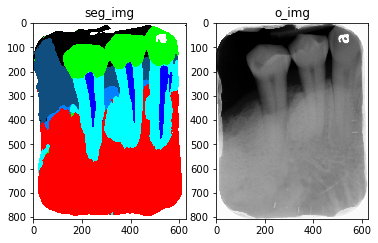

[True, False]
[False]


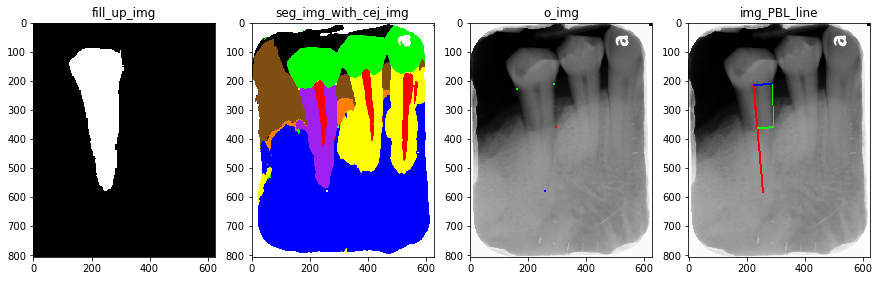

[True, False]
[False]


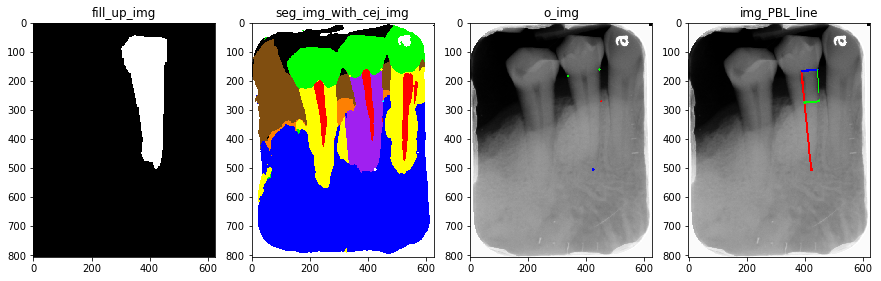

[True, False]
[True]


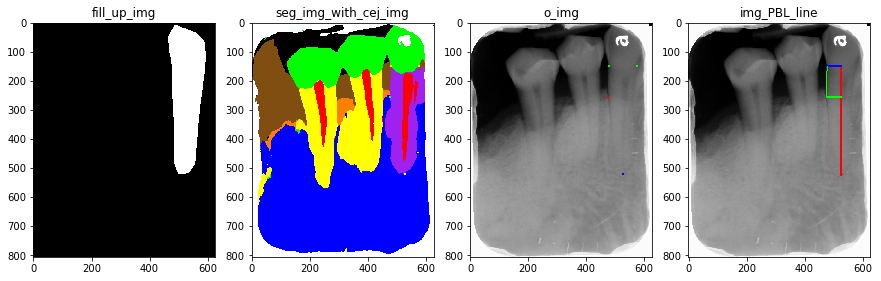


loss_root_count 0


In [22]:
folder_build_path = './'

#Using filled up tooth & segmentation with cej levle to Pattern detection key point
o_image_folder = os.path.join(folder_build_path,'1_o_image')
o_image_path_list = glob.glob(o_image_folder+'/*.PNG')
o_image_path_list.sort()

seg_image_folder = os.path.join(folder_build_path,'1_seg_image')
seg_image_path_list = glob.glob(seg_image_folder+'/*.PNG')
seg_image_path_list.sort()

split_root_folder = os.path.join(folder_build_path,'1_roots_mask')
split_root_path_list = glob.glob(split_root_folder+'/*.PNG')
split_root_path_list.sort()

seg_img_with_cej_folder = os.path.join(folder_build_path,'2_seg_img_with_cej')
seg_img_with_cej_path_list = glob.glob(seg_img_with_cej_folder+'/*.PNG')
seg_img_with_cej_path_list.sort()

json_folder = os.path.join('/root/notebooks/tooth_project/All_data_test/PBL_detection/Data/Label/*/*/*.json')
json_list = glob.glob(json_folder)
json_list.sort()

loss_root_count = 0

#pattern_detection_result_save_path = './3_pattern_detection_result'
pattern_detection_result_save_path = './3_pattern_miss_p'
draw_all_points_on_o_img_save_path = './3_draw_all_points_on_o_img'
draw_all_points_on_seg_img_save_path = './3_draw_all_points_on_seg_img'

# pattern_detection_result_save_path = os.path.join(folder_build_path,'3_pattern_detection_result')
# draw_all_points_on_o_img_save_path = os.path.join(folder_build_path,'3_draw_all_points_on_o_img')
# draw_all_points_on_seg_img_save_path = os.path.join(folder_build_path,'3_draw_all_points_on_seg_img')

# if show,save = true would show,save image what this block create
PBL_status = False
show = True
save = True
CSV = False
save_file_type = '.PNG'
print_ = False
molar = True
count = 0
tooth_count = 0
seg_image_path_list = sorted(seg_image_path_list)
seg_image_path_list = seg_image_path_list[:]

for index, seg_image_path in tqdm(enumerate(seg_image_path_list),total = len(seg_image_path_list)):
    img_name = get_name_from_path(seg_image_path,False)
    if 'NN__191111_145402_2420C' not in img_name:
        continue
    print(index)
    if True:
        if False:
            print(img_name) 
        roots_img_path_list = [root_name for root_name in split_root_path_list if img_name in root_name]
        o_img = cv2.imread(seg_image_path.replace('1_seg_image','1_o_image'),0)
        seg_img = cv2.imread(seg_image_path)
        forward, value = tooth_forward(seg_img)
        #print(value)
        #check_forward_status(value)
    #     if not forward:
        plt.subplot(121)
        plt.title('seg_img')
        plt.imshow(seg_img)
        plt.subplot(122)
        plt.title('o_img')
        plt.imshow(o_img, cmap = 'gray')
        plt.show()
        #print(check_forward_status(value))

        if forward:
            target_json_file = [file_path for file_path in json_list if img_name in file_path]
            if len(target_json_file)==0:
                loss_root_count+=1
                continue
            for fill_up_path in roots_img_path_list:
                count+=1
                o_img_copy = o_img.copy()
                
                fill_up_name = get_name_from_path(fill_up_path,True)
                fill_up_img = cv2.imread(fill_up_path,0)
                fill_up_img = cv2.resize(fill_up_img,o_img_copy.shape[:2][::-1],interpolation = cv2.INTER_NEAREST)
                
                seg_img_with_cej_img = cv2.imread(fill_up_path.replace('1_roots_mask','2_seg_img_with_cej'))
                check_point = (np.mean(np.nonzero(fill_up_img)[1]),np.mean(np.nonzero(fill_up_img)[0]))
                molar = get_molar_bool(target_json_file[0], check_point)
                root_x, root_y,line_of_inertia = root_point_detect(fill_up_img,value)

#                 (cej_x,cej_y),(bone_x,bone_y) = find_cej_bone_keypoint(seg_img_with_cej_img, fill_up_img, line_of_inertia,value, molar)


                
                bone_x = []
                bone_y = []
                ####################################
                ####################################
                (cej_x,cej_y),(bone_x,bone_y) = find_cej_bone_keypoint(seg_img_with_cej_img)
                (cej_x,cej_y),(bone_x,bone_y) = keypoint_filter(zip(cej_x,cej_y),zip(bone_x,bone_y),line_of_inertia,value,fill_up_img)
                
#                 if (len(cej_x) == 1) and (len(cej_y) == 1):
#                     (cej_x, cej_y) = cej_recover(cej_x, cej_y, line_of_inertia, fill_up_img)
#                 if (len(bone_x) < 2) and (len(bone_y) < 2):
#                     (bone_x, bone_y) = bone_recover(bone_x, bone_y, fill_up_img, line_of_inertia, seg_img_with_cej_img, value, molar)
                    
                ####################################
                #################################### 
                if root_x[0] != None:
                    if print_:
                        print('Find {} root point in this image'.format(len(root_x)))
                        print(root_x,root_y)
                        print('Find {} cej point in this image'.format(len(cej_x)))
                        print(cej_x,cej_y)
                        print('Find {} bone point in this image'.format(len(bone_x)))
                        print(bone_x,bone_y)
                    #molar = True
                    PBL_status, LPBL, L_Stage, RPBL, R_Stage,Dis_L,Dis_R,Dis_root,img_PBL_line,points_info = PBL_Detect(fill_up_img, value, o_img_copy, zip(root_x,root_y), zip(cej_x,cej_y), zip(bone_x,bone_y), line_of_inertia, molar)

                    if print_:
                        print('Dectation LPBL is : {}%'.format(LPBL))
                        print('Dectation RPBL is : {}%'.format(RPBL))
                    tooth_pbl_line_path = os.path.join(pattern_detection_result_save_path,fill_up_name)
                    tooth_pbl_draw_all_points_on_o_img_path = os.path.join(draw_all_points_on_o_img_save_path,fill_up_name)
                    tooth_pbl_draw_all_points_on_seg_img_path = os.path.join(draw_all_points_on_seg_img_save_path,fill_up_name)
                    ####################
                    if CSV:
                        # List of strings
                        #example:['Image_name', 'Tooth_num', 'LPBL', 'L_Stage', 'RPBL', 'R_Stage','tooth_pbl_line_path']
                        row_contents = [img_name, fill_up_name, LPBL, L_Stage , RPBL, R_Stage,Dis_L,Dis_R,Dis_root,points_info,tooth_pbl_line_path]

                        # Append a list as new line to an old csv file
                        append_list_as_row(csv_file_path, row_contents)
                    ####write points
                    o_img_copy = cv2.cvtColor(o_img_copy, cv2.COLOR_GRAY2RGB)
                    for x,y in zip(root_x,root_y):
                        cv2.circle(o_img_copy,(x, y), 4, (0, 0, 255), -1)
                        cv2.circle(seg_img_with_cej_img,(x, y), 4, (255, 255, 255), -1)
                    for x,y in zip(bone_x,bone_y):
                        cv2.circle(o_img_copy,(x, y), 4, (255, 0, 0), -1)
                        cv2.circle(seg_img_with_cej_img,(x, y), 4, (255, 255, 0), -1)
                    for x,y in zip(cej_x,cej_y):
                        cv2.circle(o_img_copy,(x, y), 4, (0, 255, 0), -1)
                        cv2.circle(seg_img_with_cej_img,(x, y), 4, (0, 255, 255), -1)
                    ##############
                    if save:
                        cv2.imwrite(tooth_pbl_line_path, img_PBL_line)
                        cv2.imwrite(tooth_pbl_draw_all_points_on_o_img_path, o_img_copy)
                        cv2.imwrite(tooth_pbl_draw_all_points_on_seg_img_path, seg_img_with_cej_img)
                    if show and PBL_status:
                        plt.figure(figsize=(15,15))
                        plt.subplot(141)
                        plt.title('fill_up_img')
                        plt.imshow(fill_up_img, cmap = 'gray')
                        plt.subplot(142)
                        plt.title('seg_img_with_cej_img')
                        plt.imshow(cv2.cvtColor(seg_img_with_cej_img,cv2.COLOR_BGR2RGB))
                        plt.subplot(143)
                        plt.title('o_img')
                        plt.imshow(o_img_copy)
                        plt.subplot(144)
                        plt.title('img_PBL_line')
                        plt.imshow(cv2.cvtColor(img_PBL_line,cv2.COLOR_BGR2RGB))
                        plt.show()
                    elif show:
                        plt.figure(figsize=(12,12))
                        plt.subplot(131)
                        plt.title('fill_up_img')
                        plt.imshow(fill_up_img, cmap = 'gray')
                        plt.subplot(132)
                        plt.title('seg_img_with_cej_img')
                        plt.imshow(cv2.cvtColor(seg_img_with_cej_img,cv2.COLOR_BGR2RGB))
                        plt.subplot(133)
                        plt.title('o_img')
                        plt.imshow(cv2.cvtColor(o_img_copy,cv2.COLOR_BGR2RGB))
                        plt.show()
                else:
                    print("can't find the root", fill_up_name)
print('loss_root_count',loss_root_count)

In [ ]:
# def find_cej_bone_keypoint(img_BGR_array):
#     kernel = np.ones((5,5),np.uint8)
#     img_gray = cv2.cvtColor(img_BGR_array,cv2.COLOR_BGR2GRAY)
    
#     tooth_mask = np.where(img_gray==94,1,0).astype('uint8')
#     tooth_mask_rm_p = remove_pieces_300(tooth_mask)
#     tooth_contour = cv2.morphologyEx(tooth_mask_rm_p, cv2.MORPH_GRADIENT, kernel)
    
#     background_mask = np.where(img_gray==0,1,np.where(img_gray==86,1,np.where(img_gray==151,1,0))).astype('uint8')
#     background_mask_rm_p = remove_pieces_50(background_mask)
#     background_contour = cv2.morphologyEx(background_mask_rm_p, cv2.MORPH_GRADIENT, kernel)
    
#     cej_crown_mask = np.where(img_gray==150,1,np.where(img_gray==179,1,0)).astype('uint8')
#     cej_crown_mask_rm_p = remove_pieces_300(cej_crown_mask)

#     gums_mask = np.where(img_gray==29,1,0).astype('uint8')
#     gums_mask_rm_p = remove_pieces_300(gums_mask)
    
#     plt.imshow(tooth_contour)
#     plt.show()
#     plt.imshow(background_contour)
#     plt.show()
#     plt.imshow(cej_crown_mask_rm_p)
#     plt.show()
#     plt.imshow(gums_mask_rm_p)
#     plt.show()
#     cej = tooth_contour*background_contour*cej_crown_mask_rm_p
#     bone = tooth_contour*background_contour*gums_mask_rm_p
    
#     cej_point = np.nonzero(cej)
#     bone_point = np.nonzero(bone)
#     return (cej_point[1],cej_point[0]), (bone_point[1],bone_point[0])

In [ ]:
# def point_in_left_side_of_line(point,line_edge1,line_edge2):
#     dy = line_edge2[1]-line_edge1[1]
#     dx = line_edge2[0]-line_edge1[0]
#     if(dx==0):
#         if(line_edge2[0]>point[0]):
#             return True
#         else:
#             return False
#     if(dy==0):
#         dy = 1   
#     try:
#         m = (dy/dx)
#     except:
#         print('gradient error')
#     c = line_edge1[1]-m*line_edge1[0]
#     if (point[1] - (m*point[0]) - c) < 0:
#         return True
#     else:
#         return False

In [ ]:
# line_of_inertia[0],line_of_inertia[1] (506, 1423) (369, -571)
# cej_final_points: [(399, 480)]
# cej_final_side: [False]
# 1
# cej_num_list: [False]
# cej_right_points: (399, 480)
# cej_left_points: []
# bone_num_list: [False]
# bone_right_points: [(394, 452)]
# bone_left_points: []
# cej_x: [399]
# cej_y: [480]
# cej_x: [399] cej_y: [480]
# bone_x: [394] bone_y: [452]
# -------------------------------
# L_side: False R_side: True

In [ ]:
point_in_left_side_of_line((0, 0),(506, 1423),(369, -571))

In [ ]:
point_in_left_side_of_line((0, 0),(4, 0),(0, 4))

In [ ]:
# def point_in_left_side_of_line(point,line_edge1,line_edge2):
#     try:
#         m = (line_edge2[1]-line_edge1[1])/(line_edge2[0]-line_edge1[0])
#     except:
#         m = (line_edge2[1]-line_edge1[1])/(1)
#     c = line_edge1[1]-m*line_edge1[0]
#     if (point[1] - c)/m >= point[0]:
#         return True
#     else:
#         return False
    

In [ ]:
line_of_inertia[0]: (253, 1318)
line_of_inertia[1]: (58, -672)
cej_points: [(75, 252)]
bone_points: [(219, 362)]

In [ ]:
img = np.ones((10,10,3),np.uint8)
purple = np.array([240, 32, 160])
red = np.array([0, 0, 255])
img = img*purple

img_gray = cv2.cvtColor(img.astype('uint8'),cv2.COLOR_BGR2GRAY)
print(img_gray[0][0])

In [ ]:
plt.imshow(cv2.cvtColor(img.astype('uint8'),cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
point_in_left_side_of_line((4,4),(0,4),(4,0))

In [ ]:
# def PBL_Detect(imgarray,roots_point,cej_points,bone_points,line_of_inertia):
#     print_ = False
#     roots_point = list(sorted(roots_point, key = lambda x:x[0]))
#     cej_points = list(sorted(cej_points, key = lambda x:x[0]))
#     bone_points = list(sorted(bone_points, key = lambda x:x[0]))
#     RGB_image = cv2.cvtColor(imgarray, cv2.COLOR_GRAY2RGB)
#     img_PBL_line = RGB_image.copy()
#     L_side = False
#     R_side = False
#     cej_num_list = [point_in_left_side_of_line(cej,line_of_inertia[0],line_of_inertia[1]) for cej in cej_points]
#     bone_num_list = [point_in_left_side_of_line(bone,line_of_inertia[0],line_of_inertia[1]) for bone in bone_points]
    
#     if sum(cej_num_list) == 1 and sum(bone_num_list) == 1:
#         R_side = True
#     if len(cej_points) - sum(cej_num_list) == 1 and len(bone_points) - sum(bone_num_list)==1:
#         L_side = True
#     points_info = tuple((sum(cej_num_list),sum(bone_num_list),len(cej_points) - sum(cej_num_list),len(bone_points) - sum(bone_num_list)))
#     if print_:
#         print('L_side:',L_side,'R_side:',R_side)
#         print('roots_point:',roots_point)
#         print('bone_points:',bone_points)
#         print('cej_points:',cej_points)
#     if L_side and R_side:
#         cej_center_point = [int((cej_points[0][0]+cej_points[1][0])/2),int((cej_points[0][1]+cej_points[1][1])/2)]
#         cv2.line(img_PBL_line, (bone_points[0][0], bone_points[0][1]), (bone_points[1][0], bone_points[1][1]), (0, 255, 0), 5)
#         cv2.line(img_PBL_line, (cej_points[0][0], cej_points[0][1]), (cej_points[1][0], cej_points[1][1]), (255, 0, 0), 5)
#         cv2.line(img_PBL_line, (roots_point[0][0], roots_point[0][1]), (cej_center_point[0], cej_center_point[1]), (0, 0, 255), 5)
        
#         cv2.line(img_PBL_line, (cej_points[0][0],cej_points[0][1]), (bone_points[0][0], bone_points[0][1]), (0, 255, 0), 2)
#         cv2.line(img_PBL_line, (cej_points[1][0],cej_points[1][1]), (bone_points[1][0], bone_points[1][1]), (0, 255, 0), 2)
#         #cv2.line(img_PBL_line, (crosspoint_point2line(bone_points[0],cej_points[0],cej_points[1])), (bone_points[0][0], bone_points[0][1]), (0, 255, 0), 2)
#         #cv2.line(img_PBL_line, (crosspoint_point2line(bone_points[1],cej_points[0],cej_points[1])), (bone_points[1][0], bone_points[1][1]), (0, 255, 0), 2)
        
#         cv2.circle(img_PBL_line, (roots_point[0][0], roots_point[0][1]), 3 , (0, 0, 255), 10)
#         cv2.circle(img_PBL_line, (bone_points[0][0], bone_points[0][1]), 3 , (0, 255, 0), 10)
#         cv2.circle(img_PBL_line, (bone_points[1][0], bone_points[1][1]), 3 , (0, 255, 0), 10)
#         cv2.circle(img_PBL_line, (cej_points[0][0], cej_points[0][1]), 3 , (255, 0, 0), 10)
#         cv2.circle(img_PBL_line, (cej_points[1][0], cej_points[1][1]), 3 , (255, 0, 0), 10)
#         LPBL = (distance_point2line(np.array(bone_points[0]),np.array(cej_points[0]),np.array(cej_points[1]))*0.05-2)/(distance_2_points(np.array(roots_point[0]),np.array(cej_center_point))*0.05-2)
#         RPBL = (distance_point2line(np.array(bone_points[1]),np.array(cej_points[0]),np.array(cej_points[1]))*0.05-2)/(distance_2_points(np.array(roots_point[0]),np.array(cej_center_point))*0.05-2)

#         Dis_L = distance_point2line(np.array(bone_points[0]),np.array(cej_points[0]),np.array(cej_points[1]))
#         Dis_R = distance_point2line(np.array(bone_points[1]),np.array(cej_points[0]),np.array(cej_points[1]))
#         Dis_root = distance_2_points(np.array(roots_point[0]),np.array(cej_center_point))
#         if LPBL < 0:
#             LPBL = 0
#         if RPBL < 0:
#             RPBL = 0
#         return True, round(LPBL*100,3), PBL_stage(LPBL), round(RPBL*100,3), PBL_stage(RPBL),Dis_L,Dis_R,Dis_root, img_PBL_line,points_info
#     elif L_side:
#         RPBL = -999
#         cej_cross_point_with_inertia = crosspoint_point2line(cej_points[cej_num_list.index(True)],line_of_inertia[0],line_of_inertia[1])
#         bone_cross_point_with_inertia = crosspoint_point2line(bone_points[bone_num_list.index(True)],line_of_inertia[0],line_of_inertia[1])
#         cv2.line(img_PBL_line, (roots_point[0][0], roots_point[0][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (0, 0, 255), 5)
#         cv2.line(img_PBL_line, (cej_points[cej_num_list.index(True)][0], cej_points[cej_num_list.index(True)][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (255, 0, 0), 5)
#         cv2.line(img_PBL_line, (bone_points[bone_num_list.index(True)][0], bone_points[bone_num_list.index(True)][1]), (bone_cross_point_with_inertia[0], bone_cross_point_with_inertia[1]), (0, 255, 0), 5)
#         cv2.line(img_PBL_line, (cej_points[cej_num_list.index(True)][0],cej_points[cej_num_list.index(True)][1]), (bone_points[bone_num_list.index(True)][0], bone_points[bone_num_list.index(True)][1]), (0, 255, 0), 2)
#         LPBL = (distance_2_points(np.array(cej_points[cej_num_list.index(True)]),np.array(bone_points[bone_num_list.index(True)]))*0.05-2)/(distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))*0.05-2)
#         Dis_R = -999
#         Dis_L = distance_2_points(np.array(cej_points[cej_num_list.index(True)]),np.array(bone_points[bone_num_list.index(True)]))
#         Dis_root = distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))
#         if LPBL < 0:
#             LPBL = 0
#         return True, round(LPBL*100,3), PBL_stage(LPBL), RPBL, PBL_stage(RPBL),Dis_L,Dis_R,Dis_root,img_PBL_line,points_info
#     elif R_side:
#         LPBL = -999
#         cej_cross_point_with_inertia = crosspoint_point2line(cej_points[cej_num_list.index(False)],line_of_inertia[0],line_of_inertia[1])
#         bone_cross_point_with_inertia = crosspoint_point2line(bone_points[bone_num_list.index(False)],line_of_inertia[0],line_of_inertia[1])
#         cv2.line(img_PBL_line, (roots_point[0][0], roots_point[0][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (0, 0, 255), 5)
#         cv2.line(img_PBL_line, (cej_points[cej_num_list.index(False)][0], cej_points[cej_num_list.index(False)][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (255, 0, 0), 5)
#         cv2.line(img_PBL_line, (bone_points[bone_num_list.index(False)][0], bone_points[bone_num_list.index(False)][1]), (bone_cross_point_with_inertia[0], bone_cross_point_with_inertia[1]), (0, 255, 0), 5)
#         cv2.line(img_PBL_line, (cej_points[cej_num_list.index(False)][0],cej_points[cej_num_list.index(False)][1]), (bone_points[bone_num_list.index(False)][0], bone_points[bone_num_list.index(False)][1]), (0, 255, 0), 2)
#         RPBL = (distance_2_points(np.array(cej_points[cej_num_list.index(False)]),np.array(bone_points[bone_num_list.index(False)]))*0.05-2)/(distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))*0.05-2)
#         Dis_L = -999
#         Dis_R = distance_2_points(np.array(cej_points[cej_num_list.index(False)]),np.array(bone_points[bone_num_list.index(False)]))
#         Dis_root = distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))
#         if RPBL < 0:
#             RPBL = 0
#         return True, LPBL, PBL_stage(LPBL), round(RPBL*100,3), PBL_stage(RPBL),Dis_L,Dis_R,Dis_root,img_PBL_line,points_info
#     else:
#         LPBL, RPBL = -999, -999
#         Dis_L = -999
#         Dis_R = -999
#         Dis_root = -999
#         cv2.line(img_PBL_line, (line_of_inertia[0][0], line_of_inertia[0][1]), (line_of_inertia[1][0], line_of_inertia[1][1]), (0, 0, 255), 5)
#         return False,LPBL, PBL_stage(LPBL), RPBL, PBL_stage(RPBL),Dis_L,Dis_R,Dis_root,img_PBL_line,points_info

In [ ]:
#bone level is cloest to root
# def keypoint_filter(cej_points,bone_points,line_of_inertia,value):
#     new_list_x = []
#     new_list_y = []
#     cej_points = list(sorted(cej_points, key = lambda x:x[0]))
#     bone_points = list(sorted(bone_points, key = lambda x:x[0]))
#     cej_num_list = [point_in_left_side_of_line(cej,line_of_inertia[0],line_of_inertia[1]) for cej in cej_points]
#     bone_num_list = [point_in_left_side_of_line(bone,line_of_inertia[0],line_of_inertia[1]) for bone in bone_points]
#     cej_right_points = [cej for bool_left,cej in zip(cej_num_list,cej_points) if not bool_left]
#     cej_left_points = [cej for bool_left,cej in zip(cej_num_list,cej_points) if bool_left]
#     cej_x = []
#     cej_y = []
#     #upper tooth
#     if (value==1):
#         try:
#             cej_left_points = list(sorted(cej_left_points, key = lambda x:x[1]))[0]
#             cej_points.append(cej_left_points)
#             cej_x.append(cej_left_points[0])
#             cej_y.append(cej_left_points[1])
#         except:
#             pass
#         try:
#             cej_right_points = list(sorted(cej_right_points, key = lambda x:x[1]))[0]
#             cej_points.append(cej_right_points)
#             cej_x.append(cej_right_points[0])
#             cej_y.append(cej_right_points[1])
#         except:
#             pass
#     #lower tooth
#     if (value==0):
#         try:
#             cej_left_points = list(sorted(cej_left_points, key = lambda x:x[1],reverse=True))[0]
#             cej_points.append(cej_left_points)
#             cej_x.append(cej_left_points[0])
#             cej_y.append(cej_left_points[1])
#         except:
#             pass
#         try:
#             cej_right_points = list(sorted(cej_right_points, key = lambda x:x[1],reverse=True))[0]
#             cej_points.append(cej_right_points)
#             cej_x.append(cej_right_points[0])
#             cej_y.append(cej_right_points[1])
#         except:
#             pass

#     bone_right_points = [bone for bool_right,bone in zip(bone_num_list,bone_points) if bool_right]
#     bone_left_points = [bone for bool_right,bone in zip(bone_num_list,bone_points) if not bool_right]
#     bone_x = []
#     bone_y = []
#     #upper tooth
#     if (value==1):
#         try:
#             bone_left_points = list(sorted(bone_left_points, key = lambda x:x[1]))[0]
#             bone_x.append(bone_left_points[0])
#             bone_y.append(bone_left_points[1])
#         except:
#             pass
#         try:
#             bone_right_points = list(sorted(bone_right_points, key = lambda x:x[1]))[0]
#             bone_x.append(bone_right_points[0])
#             bone_y.append(bone_right_points[1])
#         except:
#             pass
#     #lower tooth
#     if (value==0):
#         try:
#             bone_left_points = list(sorted(bone_left_points, key = lambda x:x[1],reverse=True))[0]
#             bone_x.append(bone_left_points[0])
#             bone_y.append(bone_left_points[1])
#         except:
#             pass
#         try:
#             bone_right_points = list(sorted(bone_right_points, key = lambda x:x[1],reverse=True))[0]
#             bone_x.append(bone_right_points[0])
#             bone_y.append(bone_right_points[1])
#         except:
#             pass
#     return (cej_x,cej_y),(bone_x,bone_y)

In [ ]:
# bone level is cloest to cej
# def keypoint_filter(cej_points,bone_points,line_of_inertia,value):
#     new_list_x = []
#     new_list_y = []
#     cej_points = list(sorted(cej_points, key = lambda x:x[0]))
#     bone_points = list(sorted(bone_points, key = lambda x:x[0]))
#     cej_num_list = [point_in_left_side_of_line(cej,line_of_inertia[0],line_of_inertia[1]) for cej in cej_points]
#     bone_num_list = [point_in_left_side_of_line(bone,line_of_inertia[0],line_of_inertia[1]) for bone in bone_points]
    
#     cej_left_points = [cej for bool_left,cej in zip(cej_num_list,cej_points) if bool_left]
#     cej_right_points = [cej for bool_left,cej in zip(cej_num_list,cej_points) if not bool_left]
    
#     cej_x = []
#     cej_y = []
#     #upper tooth
#     if (value==1):
#         try:
#             cej_left_points = list(sorted(cej_left_points, key = lambda x:x[1]))[0]
#             cej_points.append(cej_left_points)
#             cej_x.append(cej_left_points[0])
#             cej_y.append(cej_left_points[1])
#         except:
#             pass
#         try:
#             cej_right_points = list(sorted(cej_right_points, key = lambda x:x[1]))[0]
#             cej_points.append(cej_right_points)
#             cej_x.append(cej_right_points[0])
#             cej_y.append(cej_right_points[1])
#         except:
#             pass
#     #lower tooth
#     if (value==0):
#         try:
#             cej_left_points = list(sorted(cej_left_points, key = lambda x:x[1],reverse=True))[0]
#             cej_points.append(cej_left_points)
#             cej_x.append(cej_left_points[0])
#             cej_y.append(cej_left_points[1])
#         except:
#             pass
#         try:
#             cej_right_points = list(sorted(cej_right_points, key = lambda x:x[1],reverse=True))[0]
#             cej_points.append(cej_right_points)
#             cej_x.append(cej_right_points[0])
#             cej_y.append(cej_right_points[1])
#         except:
#             pass
    
#     cej_final_points = [(x,y) for x,y in zip(cej_x,cej_y)]
#     cej_left_bool_list = [point_in_left_side_of_line(cej,line_of_inertia[0],line_of_inertia[1]) for cej in cej_final_points]
    
#     bone_left_points = [bone for bool_left,bone in zip(bone_num_list,bone_points) if  bool_left]
#     bone_right_points = [bone for bool_left,bone in zip(bone_num_list,bone_points) if not bool_left]
    
#     bone_x = []
#     bone_y = []
# #     print("-------------------------------")
# #     print("line_of_inertia[0],line_of_inertia[1]",line_of_inertia[0],line_of_inertia[1])
# #     print("cej_final_points:",cej_final_points)
# #     print("cej_final_side:",cej_num_list)
    
# #     print(len(bone_num_list))
# #     print("cej_num_list:",cej_num_list)
# #     print("cej_right_points:",cej_right_points)
# #     print("cej_left_points:",cej_left_points)
    
# #     print("bone_num_list:",bone_num_list)
# #     print("bone_right_points:",bone_right_points)
# #     print("bone_left_points:",bone_left_points)
# #     print("cej_x:",cej_x)
# #     print("cej_y:",cej_y)
    
#     #upper tooth
#     if (value==1):
#         try:
#             bone_left_points = list(sorted(bone_left_points, key = lambda x:x[1],reverse=True))
#             point_distance_from_cej = [distance_2_points(point,[cej_x[cej_left_bool_list.index(True)],cej_y[cej_left_bool_list.index(True)]]) for point in bone_left_points]
#             best_point = bone_left_points[np.argmin(np.array(point_distance_from_cej))]
#             bone_x.append(best_point[0])
#             bone_y.append(best_point[1])
#         except:
#             pass
#         try:
#             bone_right_points = list(sorted(bone_right_points, key = lambda x:x[1],reverse=False))
#             point_distance_from_cej = [distance_2_points(point,[cej_x[cej_left_bool_list.index(False)],cej_y[cej_left_bool_list.index(False)]]) for point in bone_right_points]
#             best_point = bone_right_points[np.argmin(np.array(point_distance_from_cej))]
#             bone_x.append(best_point[0])
#             bone_y.append(best_point[1])
#         except:
#             pass
#     #lower tooth
#     if (value==0):
#         try:
#             bone_left_points = list(sorted(bone_left_points, key = lambda x:x[1],reverse=True))
#             point_distance_from_cej = [distance_2_points(point,[cej_x[cej_left_bool_list.index(True)],cej_y[cej_left_bool_list.index(True)]]) for point in bone_left_points]
#             best_point = bone_left_points[np.argmin(np.array(point_distance_from_cej))]
#             bone_x.append(best_point[0])
#             bone_y.append(best_point[1])
#         except:
#             pass
#         try:
#             bone_right_points = list(sorted(bone_right_points, key = lambda x:x[1],reverse=False))
#             point_distance_from_cej = [distance_2_points(point,[cej_x[cej_left_bool_list.index(False)],cej_y[cej_left_bool_list.index(False)]]) for point in bone_right_points]
#             best_point = bone_right_points[np.argmin(np.array(point_distance_from_cej))]
#             bone_x.append(best_point[0])
#             bone_y.append(best_point[1])
#         except:
#             pass
# #     print("cej_x:",cej_x,"cej_y:",cej_y)
# #     print("bone_x:",bone_x,"bone_y:",bone_y)
# #     print("-------------------------------")
#     return (cej_x,cej_y),(bone_x,bone_y)

In [ ]:
#dilation test

In [ ]:
mask_zero =np.zeros((20, 20))

print(mask_zero.shape)

mask = mask_zero.copy()

for i in range(5,15):
    for j in range(5,15):
        mask[i][j]=1
# mask[0][0] = 1
# mask[19][19] = 1

kernel = np.ones((3,3),np.uint8)
contour_dilation = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)

mask_RGB = np.concatenate((np.expand_dims(mask, axis=2), np.expand_dims(contour_dilation, axis=2),np.expand_dims(mask_zero, axis=2)), axis=2)

plt.figure(figsize=(12,12))
plt.subplot(131)
plt.title('mask')
plt.scatter(x=[4.5,4.5,14.5,14.5], y=[4.5,14.5,4.5,14.5], c='b', s=8)
plt.imshow(mask, cmap='gray')
plt.subplot(132)
plt.title('contour_dilation')
plt.scatter(x=[4.5,4.5,14.5,14.5], y=[4.5,14.5,4.5,14.5], c='b', s=8)
plt.imshow(contour_dilation, cmap='gray')
plt.subplot(133)
plt.title('add')
plt.imshow(mask_RGB)
plt.show()

# plt.figure(figsize=(12,12))
# plt.imshow(mask_RGB)
# plt.scatter(x=[4.5,4.5,14.5,14.5], y=[4.5,14.5,4.5,14.5], c='b', s=8)
# plt.scatter(x=[5.5,5.5,13.5,13.5], y=[5.5,13.5,5.5,13.5], c='fuchsia', s=12)
# plt.show()

In [ ]:
seg_img_with_cej_folder = os.path.join(folder_build_path,'2_seg_img_with_cej')
seg_img_with_cej_path_list = glob.glob(seg_img_with_cej_folder+'/*.PNG')
seg_img_with_cej_path_list.sort()

In [ ]:
def show_pixel_set(img_nparray):
    a = img_nparray
    unique, counts = np.unique(a, return_counts=True)
    return dict(zip(unique, counts))

In [ ]:
for img_path in tqdm(seg_img_with_cej_path_list, total=len(seg_img_with_cej_path_list)):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gums_mask = np.where(img_gray==29,1,0).astype('uint8')
    new_mask = remove_pieces(gums_mask)
    plt.imshow(img)
    plt.show()
    plt.imshow(labels_im)
    plt.show()
    plt.imshow(new_mask)
    plt.show()
    break

In [ ]:
    gums_mask_threshold = cv2.threshold(gums_mask, 127, 255, cv2.THRESH_BINARY)[1]
    num_labels, labels_im = cv2.connectedComponents(gums_mask_threshold)

In [ ]:
def remove_pieces(mask): 
    out_image = np.zeros((mask.shape[0],mask.shape[1]), np.uint8)
    mask_255 = mask*255
    mask_threshold = cv2.threshold(mask_255, 127, 255, cv2.THRESH_BINARY)[1]
    num_labels, labels_im = cv2.connectedComponents(mask_threshold)
    pixel_num_dict = show_pixel_set(labels_im)
    print(pixel_num_dict)
    pixel_num_list = list(pixel_num_dict)
    for ele in pixel_num_list[1:]:
        if pixel_num_dict[ele] > 50:
            out_image+=np.where(labels_im==ele,1,0).astype('uint8')
    return out_image

In [ ]:
zero = np.zeros((5,5))
plt.imshow(zero)
plt.show()
zero[1,:] = 1

plt.imshow(zero)
plt.show()

zero = np.zeros((5,5))
zero[:,1] = 1

plt.imshow(zero)
plt.show()


aaa = -1
zero_n = np.concatenate((zero[:,-aaa:], zero[:,:-aaa]), axis=1)
plt.imshow(zero_n)
plt.show()